# Time series exploratory analysis for Petrobras S.A.

## Libraries and packages

In [1]:
from pandas_datareader import data as pdr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import matplotlib.ticker as mtick 
import yfinance as yfin
# data extraction 
from yahooquery import Ticker

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

## Functions

In [2]:
def open_data(path):
    '''read a csv file and returns a dataframe'''
    
    dataframe = pd.read_csv(path, encoding='latin-1')
    
    return dataframe

In [3]:
def correct_data(dataframe, old_column, new_columns, split_point):
    '''correct data formatting'''
    
    dataframe[new_columns] = dataframe[old_column].str.split(split_point, expand=True)
    dataframe = dataframe.drop(old_column, axis=1)
    
    return dataframe

In [4]:
def correct_multindex(data, level, column_exclusion): 
    '''transform a multindex dataframe into a dataframe with only one index'''
    
    data = data.reset_index(level=level)
    data = data.drop(column_exclusion, axis=1)
    
    return data

In [5]:
def convert_datatypes(dataframe, column_to_numeric, column_to_date):
    '''change the datatype of two columns from object to numeric and date'''

    dataframe[column_to_numeric] = pd.to_numeric(dataframe[column_to_numeric])
    dataframe[column_to_date] = pd.to_datetime(dataframe[column_to_date], format='%d/%m/%Y')
    
    return dataframe

## Data

### Exchange rate

In [6]:
exchange_rate = open_data(r"C:\Users\caiol\Petrobras S.A\Dados_input\Câmbio_diário(1984-2023)_v2.csv")

In [7]:
exchange_rate = correct_data(exchange_rate, 'Data;Cambio', ['Date', 'Exchange_rate'], ';')
exchange_rate = convert_datatypes(exchange_rate, column_to_numeric = 'Exchange_rate', column_to_date = 'Date')

In [8]:
exchange_rate

Date  Exchange_rate
0    1990-01-02         11.524
1    1990-01-03         11.751
2    1990-01-04         11.983
3    1990-01-05         12.209
4    1990-01-08         12.440
...         ...            ...
8392 2023-06-26          4.769
8393 2023-06-27          4.790
8394 2023-06-28          4.856
8395 2023-06-29          4.858
8396 2023-06-30          4.819

[8397 rows x 2 columns]

### SELIC

In [9]:
selic = open_data(r"C:\Users\caiol\Petrobras S.A\Dados_input\SELIC(2000-2023).csv")

In [10]:
selic = correct_data(selic, 'Data;Selic', ['Date', 'Selic'], ';')
selic = convert_datatypes(selic, column_to_numeric = 'Selic', column_to_date = 'Date')

### Oil price

In [11]:
oil = open_data(r"C:\Users\caiol\Petrobras S.A\Dados_input\petróleo_preço(1987-2023).csv")

In [12]:
oil = correct_data(oil, 'Data;Preço do petróleo brent(dólares/barril)', ['Date', 'Oil_price'], ';')
oil = convert_datatypes(oil, column_to_numeric = 'Oil_price', column_to_date = 'Date')

In [13]:
oil = oil.loc[oil['Date'] >= '2001-12-31']

In [14]:
oil.head()

Date  Oil_price
3709 2001-12-31      19.35
3710 2002-01-02      20.13
3711 2002-01-03      20.47
3712 2002-01-04      21.20
3713 2002-01-07      21.08

### Stock price

In [15]:
stock = Ticker("PETR4.SA")
stock = stock.history(period="max")
stock_price = stock['adjclose']
stock_price = pd.DataFrame(stock_price, columns =['adjclose'])

In [16]:
stock_price = correct_multindex(stock_price, level=[0, 1], column_exclusion = 'symbol')
stock_price = stock_price.drop(stock_price.tail(1).index)
stock_price = convert_datatypes(stock_price, column_to_numeric = 'adjclose', column_to_date='date')
stock_price = stock_price.rename(columns={"date": "Date", "adjclose": "petro_close"})

In [17]:
petro_prices = stock_price
petro_prices

Date  petro_close
0    2000-01-03     1.450586
1    2000-01-04     1.370341
2    2000-01-05     1.356514
3    2000-01-06     1.351823
4    2000-01-07     1.357995
...         ...          ...
6029 2024-01-05    38.720001
6030 2024-01-08    38.430000
6031 2024-01-09    38.099998
6032 2024-01-10    37.750000
6033 2024-01-11    38.070000

[6034 rows x 2 columns]

In [18]:
exchange_rate

Date  Exchange_rate
0    1990-01-02         11.524
1    1990-01-03         11.751
2    1990-01-04         11.983
3    1990-01-05         12.209
4    1990-01-08         12.440
...         ...            ...
8392 2023-06-26          4.769
8393 2023-06-27          4.790
8394 2023-06-28          4.856
8395 2023-06-29          4.858
8396 2023-06-30          4.819

[8397 rows x 2 columns]

In [19]:
petro_prices = petro_prices.merge(exchange_rate, on='Date')
petro_prices = petro_prices.merge(selic, on='Date')
petro_prices = petro_prices.merge(oil, on='Date')

In [20]:
petro_prices

Date  petro_close  Exchange_rate  Selic  Oil_price
0    2001-12-31     1.578670          2.320  19.00      19.35
1    2002-01-02     1.581756          2.306  19.00      20.13
2    2002-01-03     1.592558          2.292  19.00      20.47
3    2002-01-04     1.582682          2.309  19.00      21.20
4    2002-01-07     1.617249          2.342  19.00      21.08
...         ...          ...            ...    ...        ...
5234 2023-06-20    28.357922          4.792  13.75      75.79
5235 2023-06-21    29.545300          4.779  13.75      76.92
5236 2023-06-22    29.174242          4.774  13.75      73.93
5237 2023-06-23    27.977589          4.779  13.75      73.56
5238 2023-06-26    28.608383          4.769  13.75      73.86

[5239 rows x 5 columns]

## Time series plot

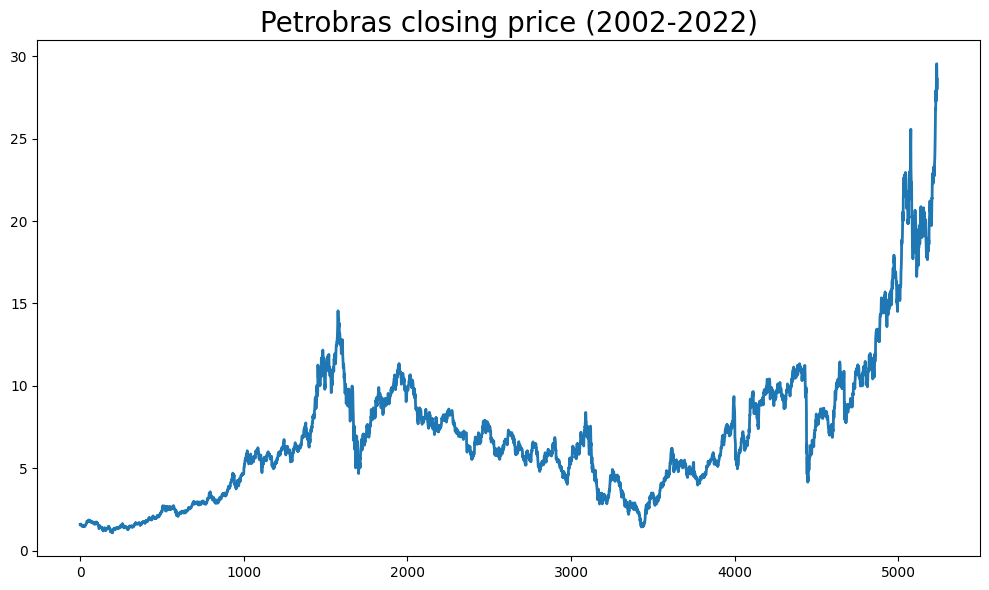

In [21]:
# gráfico do preço de fechamento (Close)
fig, ax = plt.subplots(figsize=(10, 6))
petro_prices['petro_close'].plot(kind='line', ax=ax, linewidth=2)
ax.set_title('Petrobras closing price (2002-2022)', fontsize=20)
plt.tight_layout()

In [22]:
def decompose(df, column_name): 
    result_mul = seasonal_decompose(df[column_name], model='multiplicative',
                                   period=252)
    result_add = seasonal_decompose(df[column_name], model = 'additive', 
                                    period=252)
    
    plt.rcParams.update({'figure.figsize': (20, 10)})
    result_mul.plot().suptitle('Multiplicative Decompose', fontsize=30)
    result_add.plot().suptitle('Additive Decompose', fontsize=30)
    plt.show()
    
    return result_mul, result_add

## Decomposing the time series

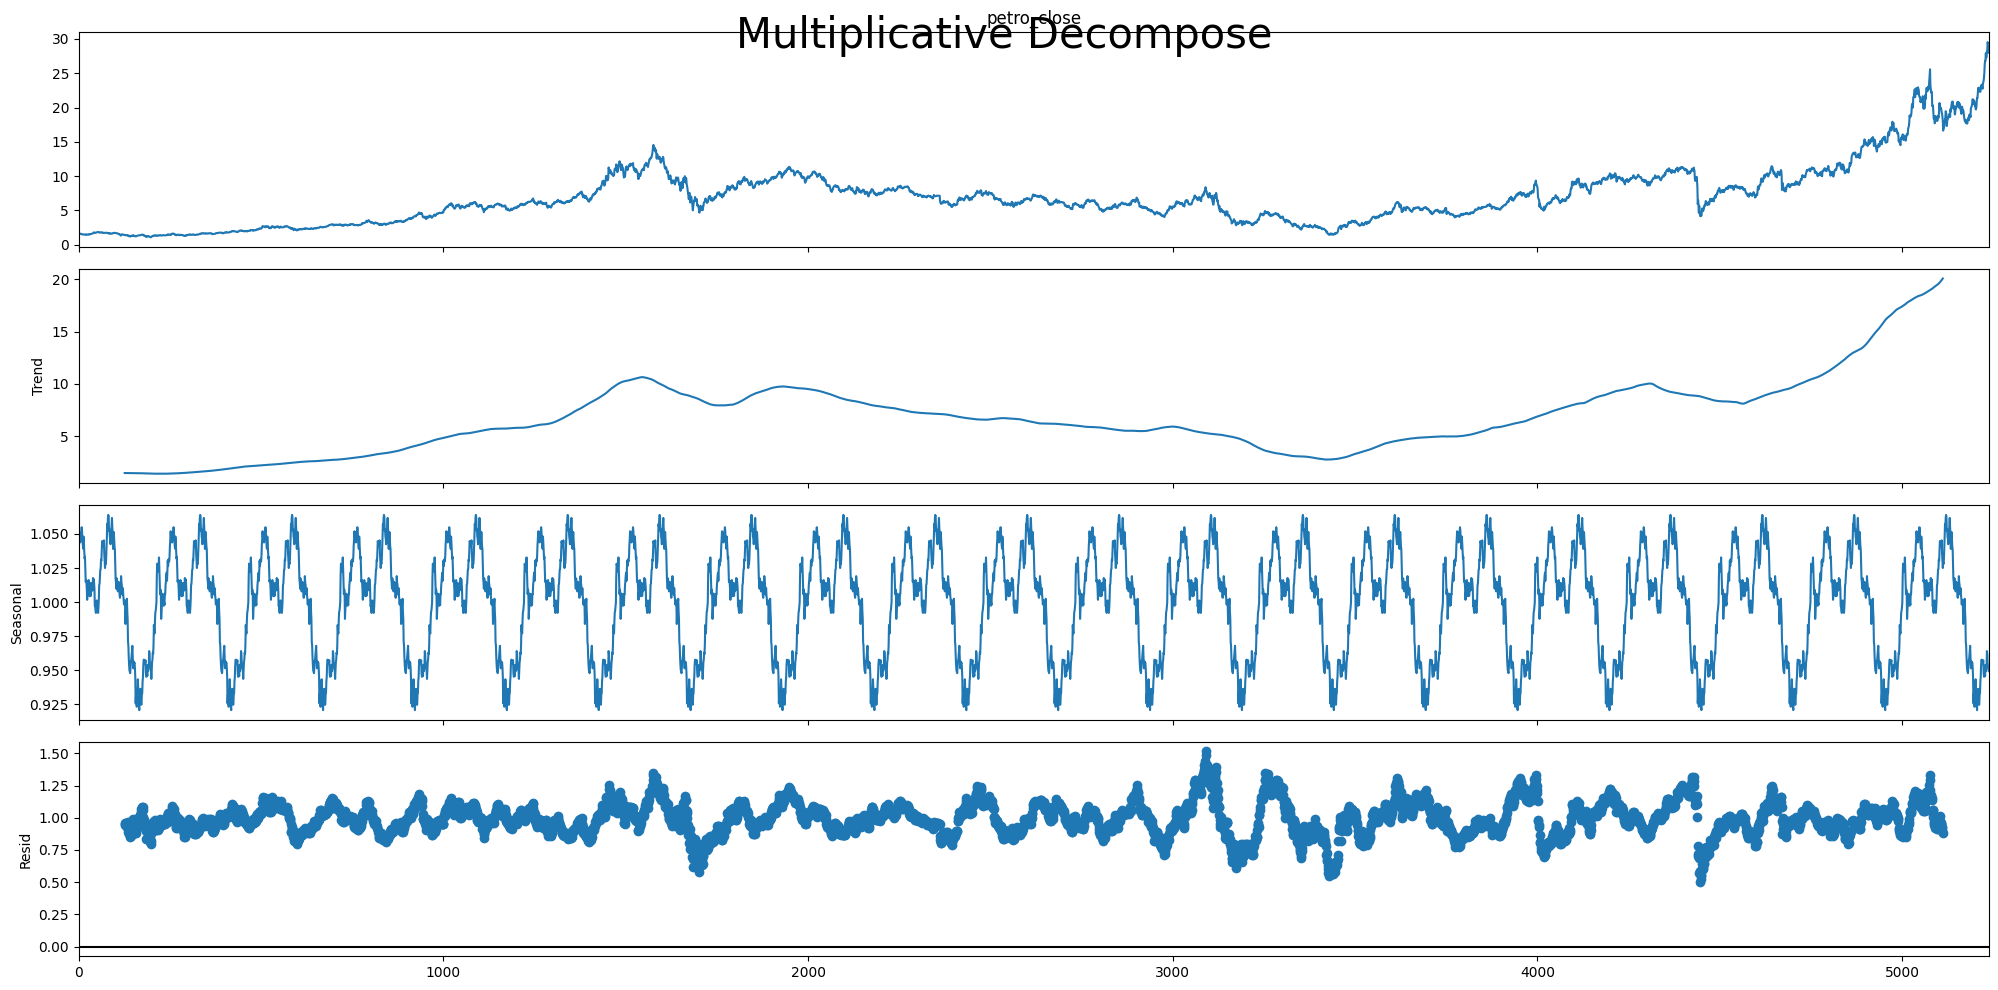

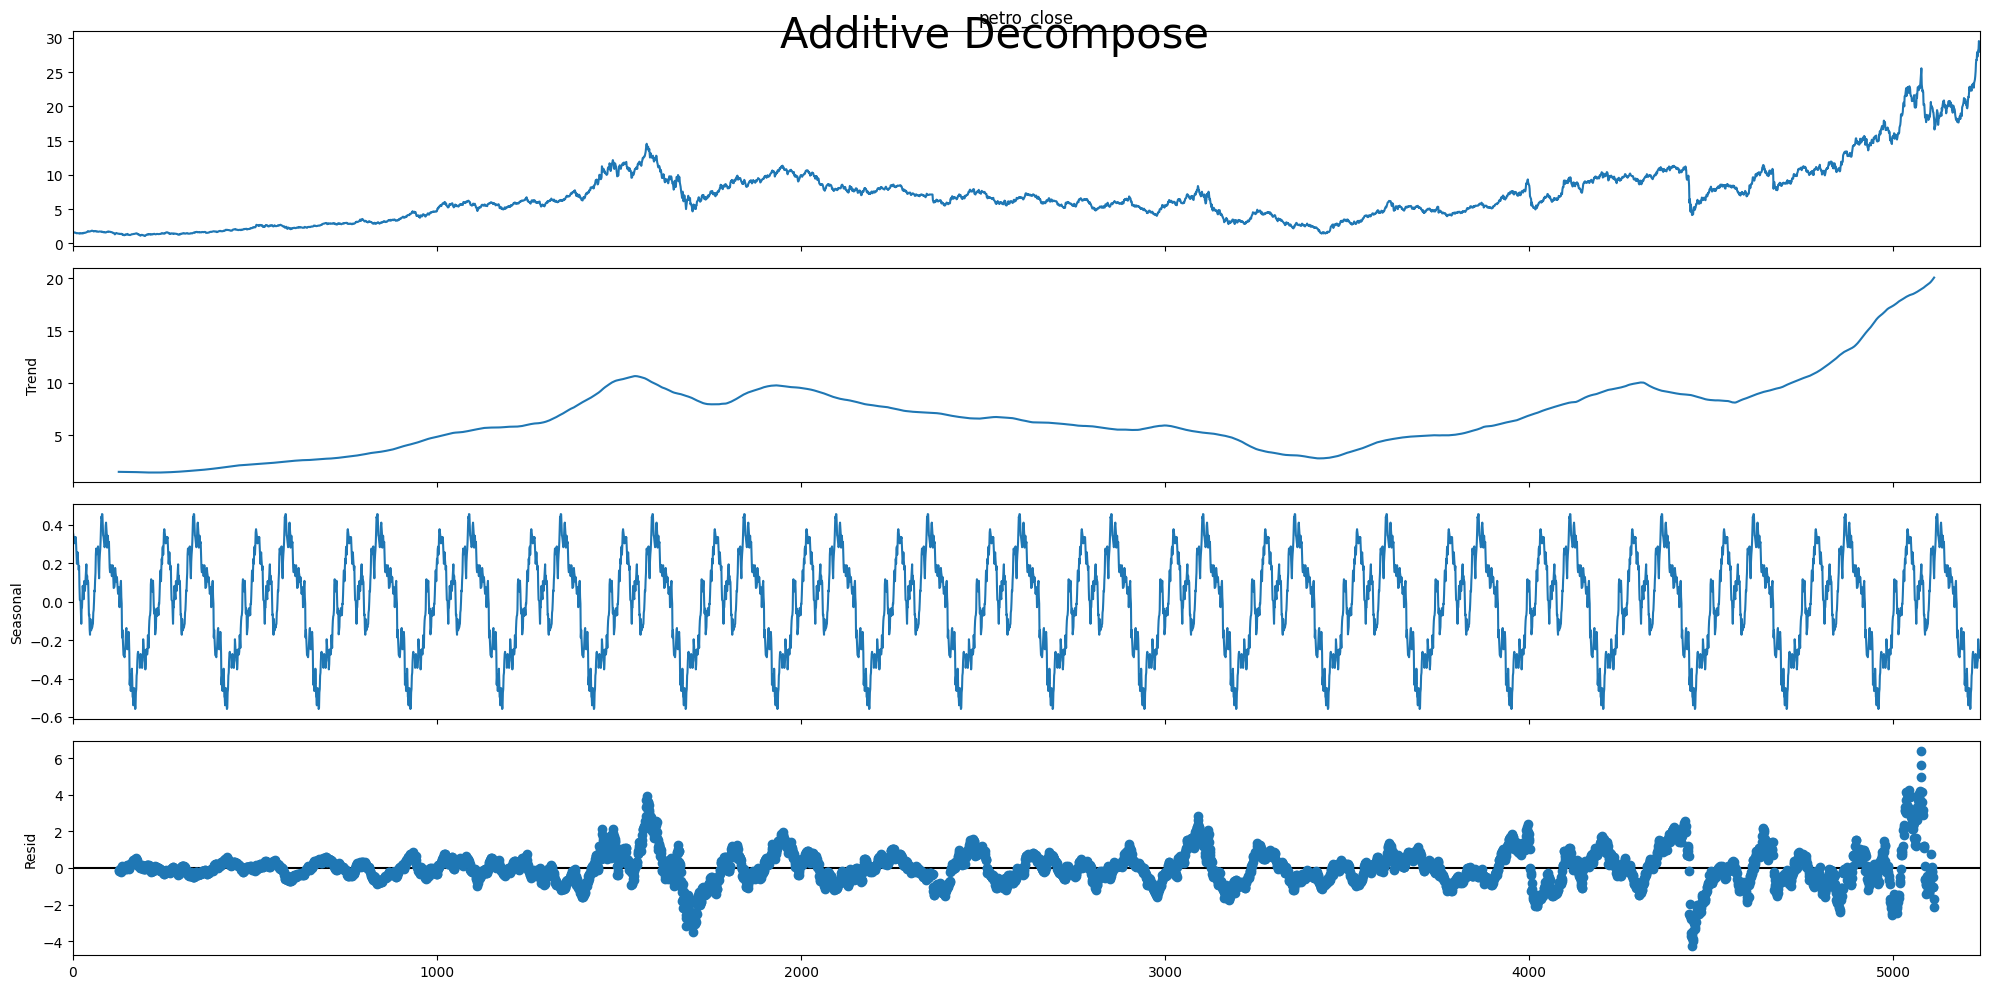

In [23]:
result_mul, result_add = decompose(df = petro_prices, column_name = 'petro_close')

## Lag plots

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

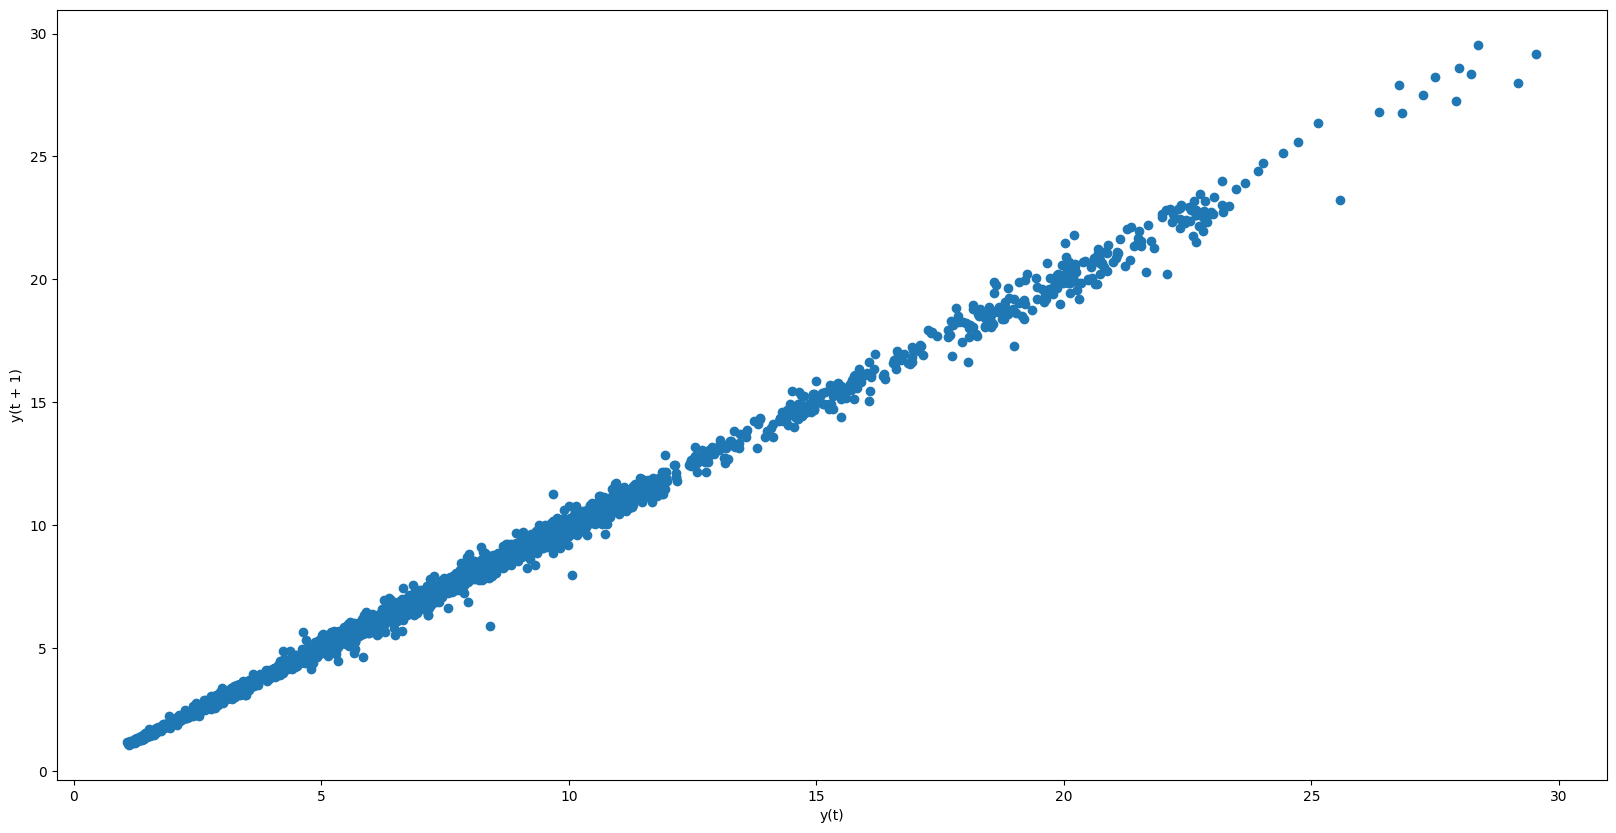

In [24]:
pd.plotting.lag_plot(petro_prices['petro_close'], lag = 1)

<Axes: xlabel='y(t)', ylabel='y(t + 2)'>

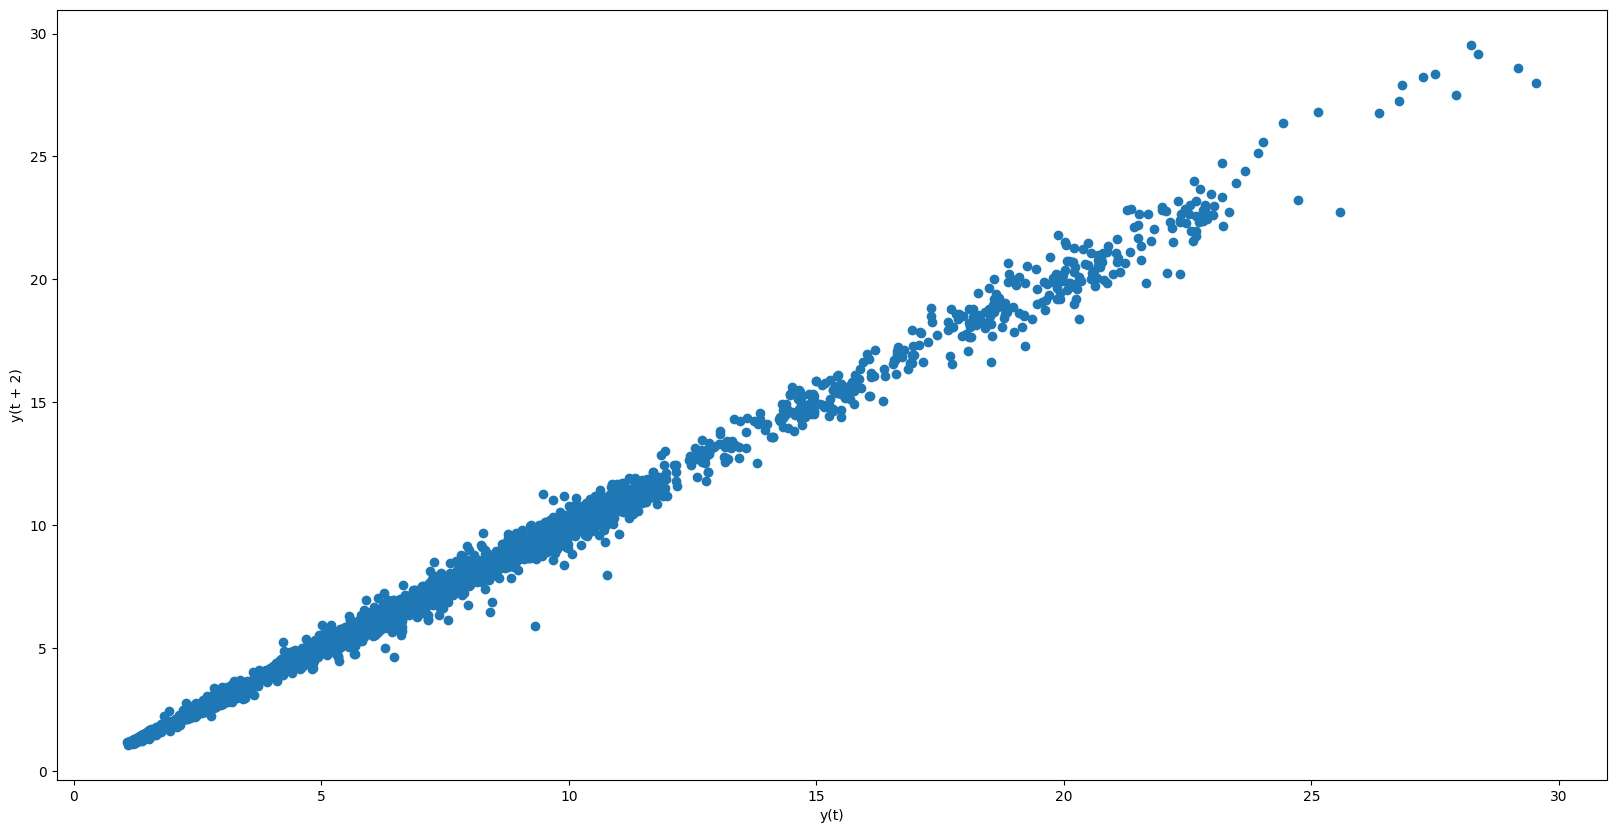

In [25]:
pd.plotting.lag_plot(petro_prices['petro_close'], lag = 2)

<Axes: xlabel='y(t)', ylabel='y(t + 3)'>

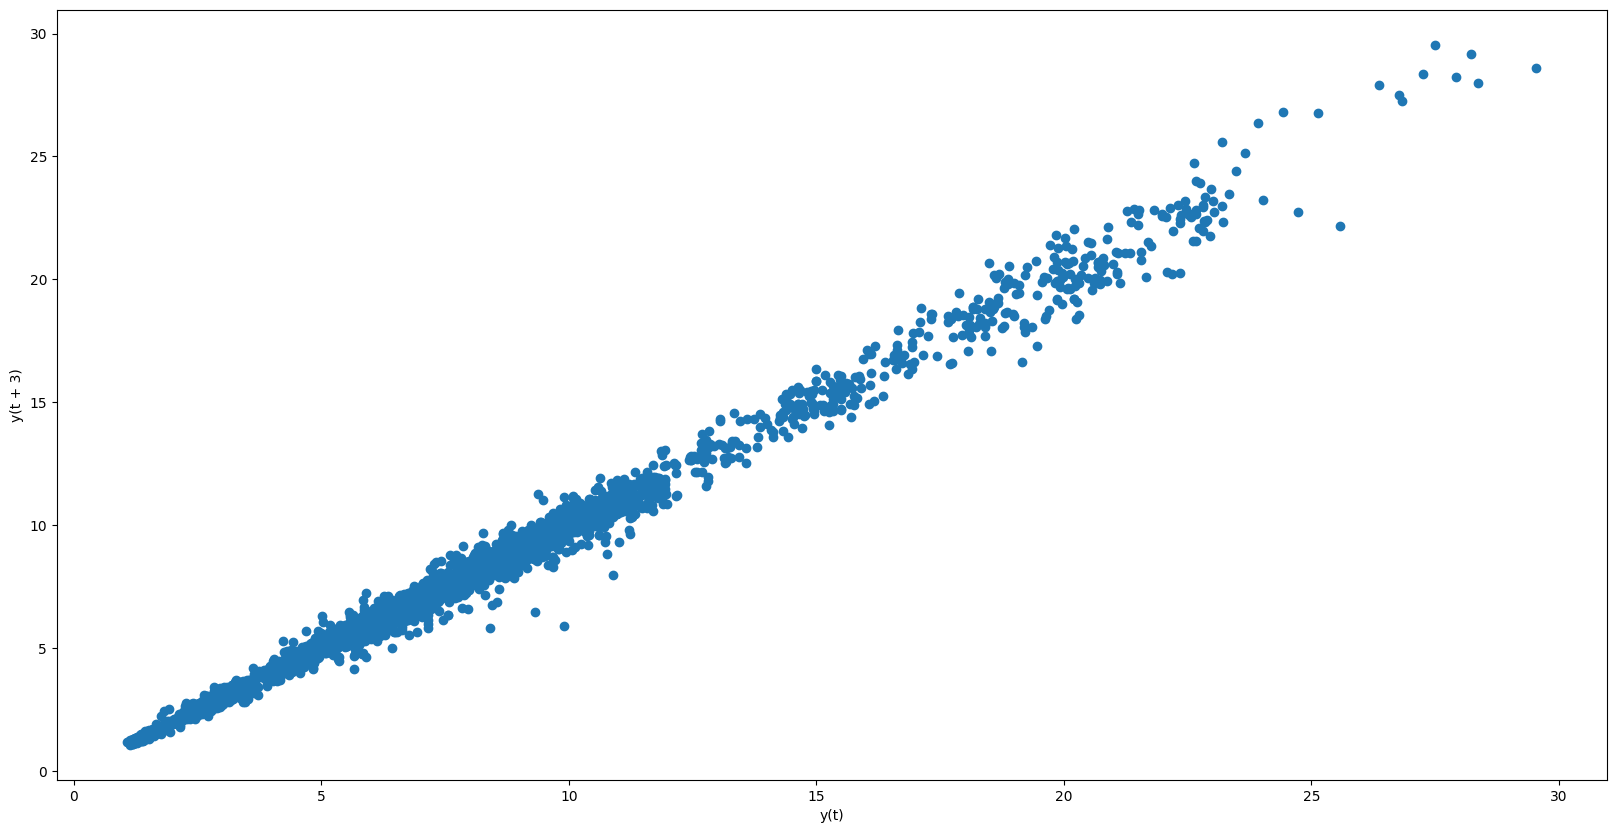

In [26]:
pd.plotting.lag_plot(petro_prices['petro_close'], lag = 3)

<Axes: xlabel='y(t)', ylabel='y(t + 4)'>

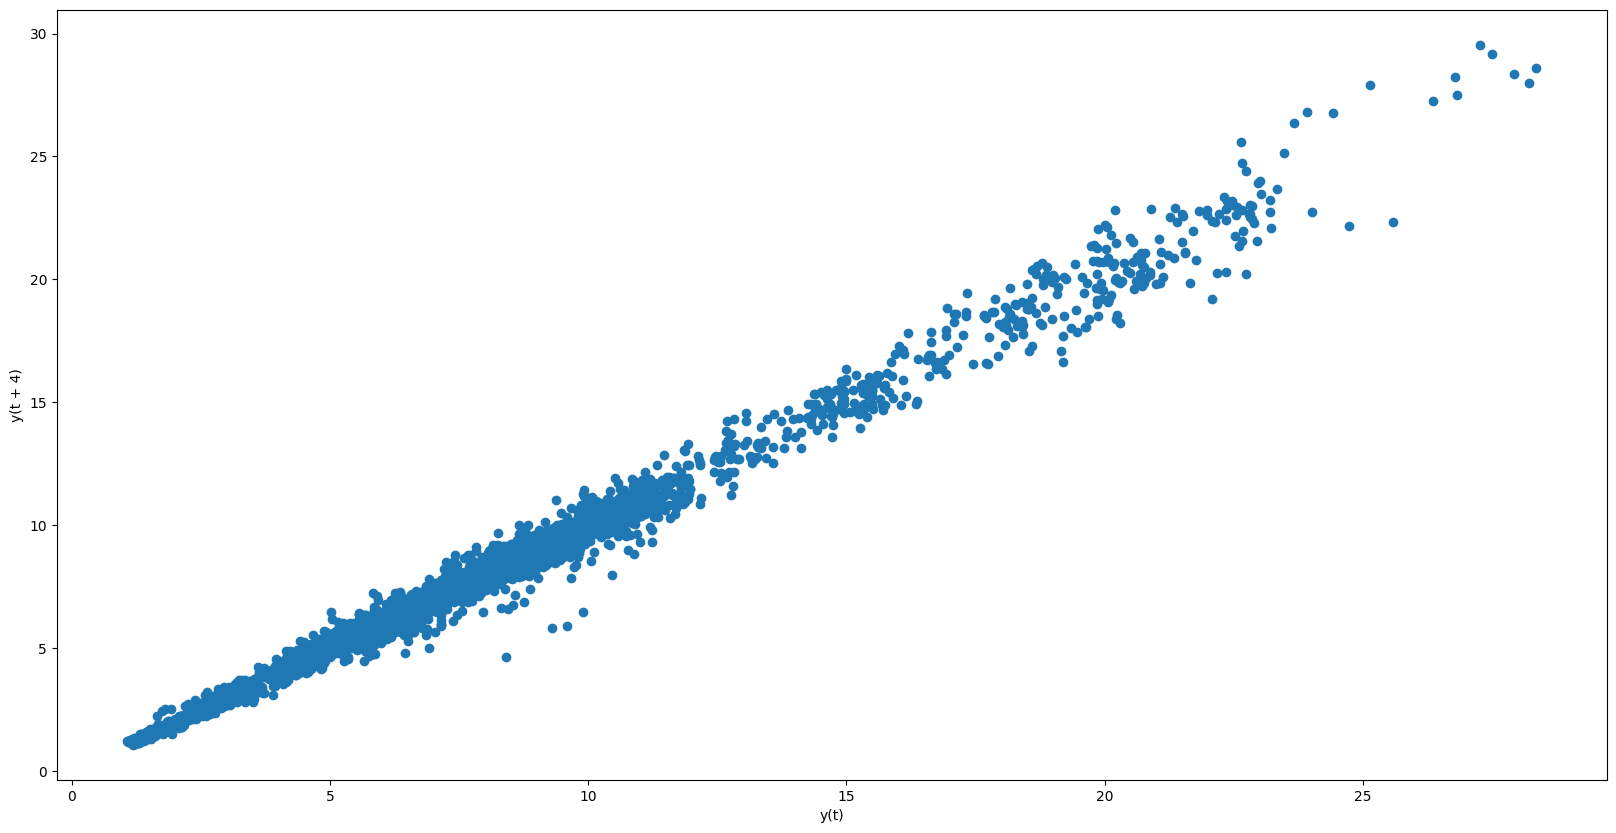

In [27]:
pd.plotting.lag_plot(petro_prices['petro_close'], lag = 4)

<Axes: xlabel='y(t)', ylabel='y(t + 5)'>

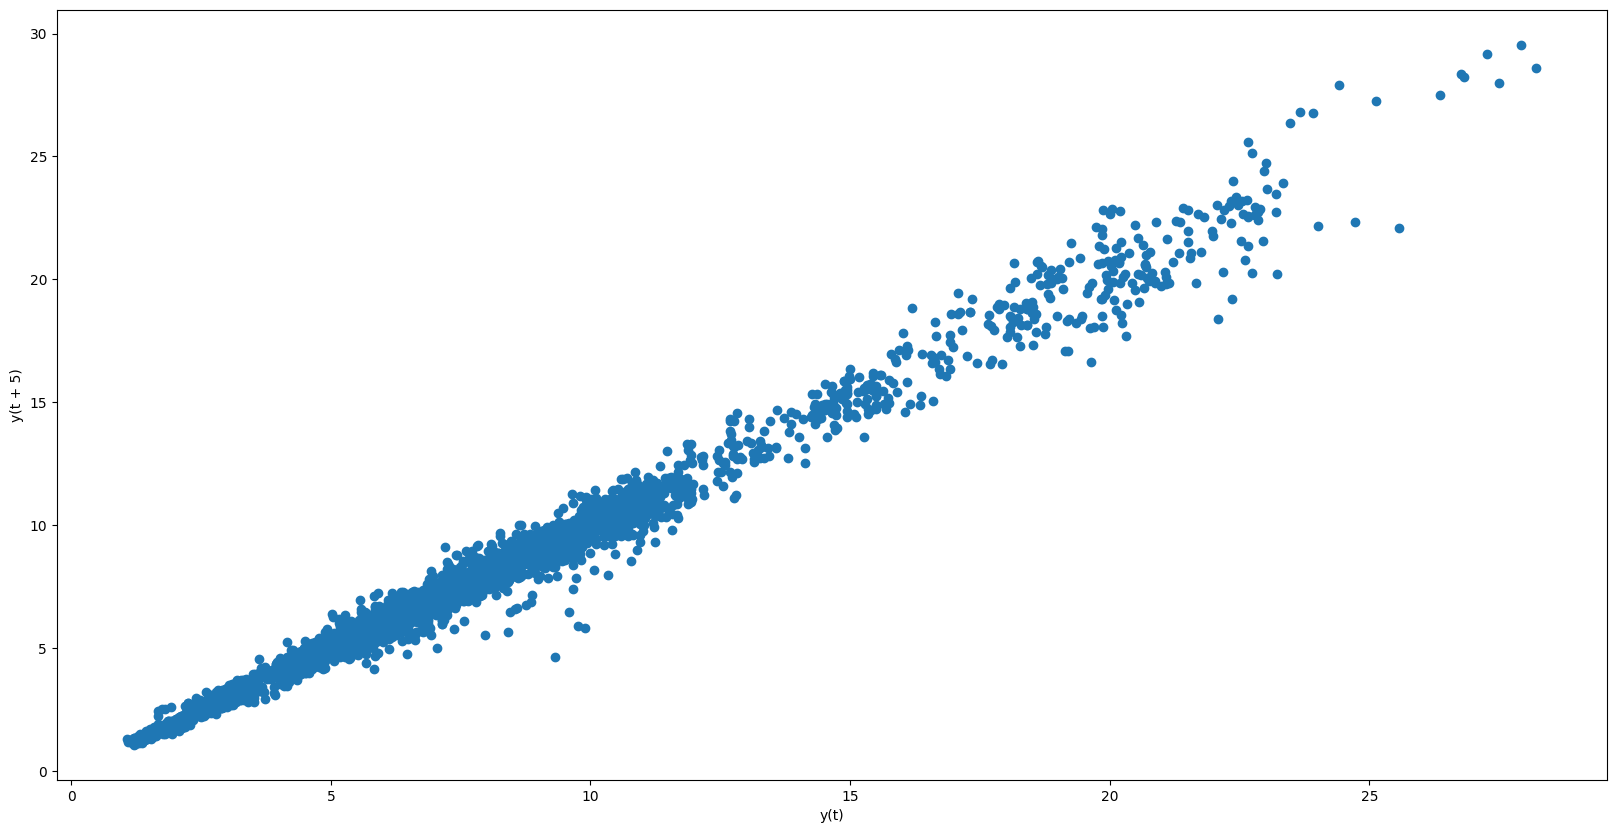

In [28]:
pd.plotting.lag_plot(petro_prices['petro_close'], lag = 5)

<Axes: xlabel='y(t)', ylabel='y(t + 6)'>

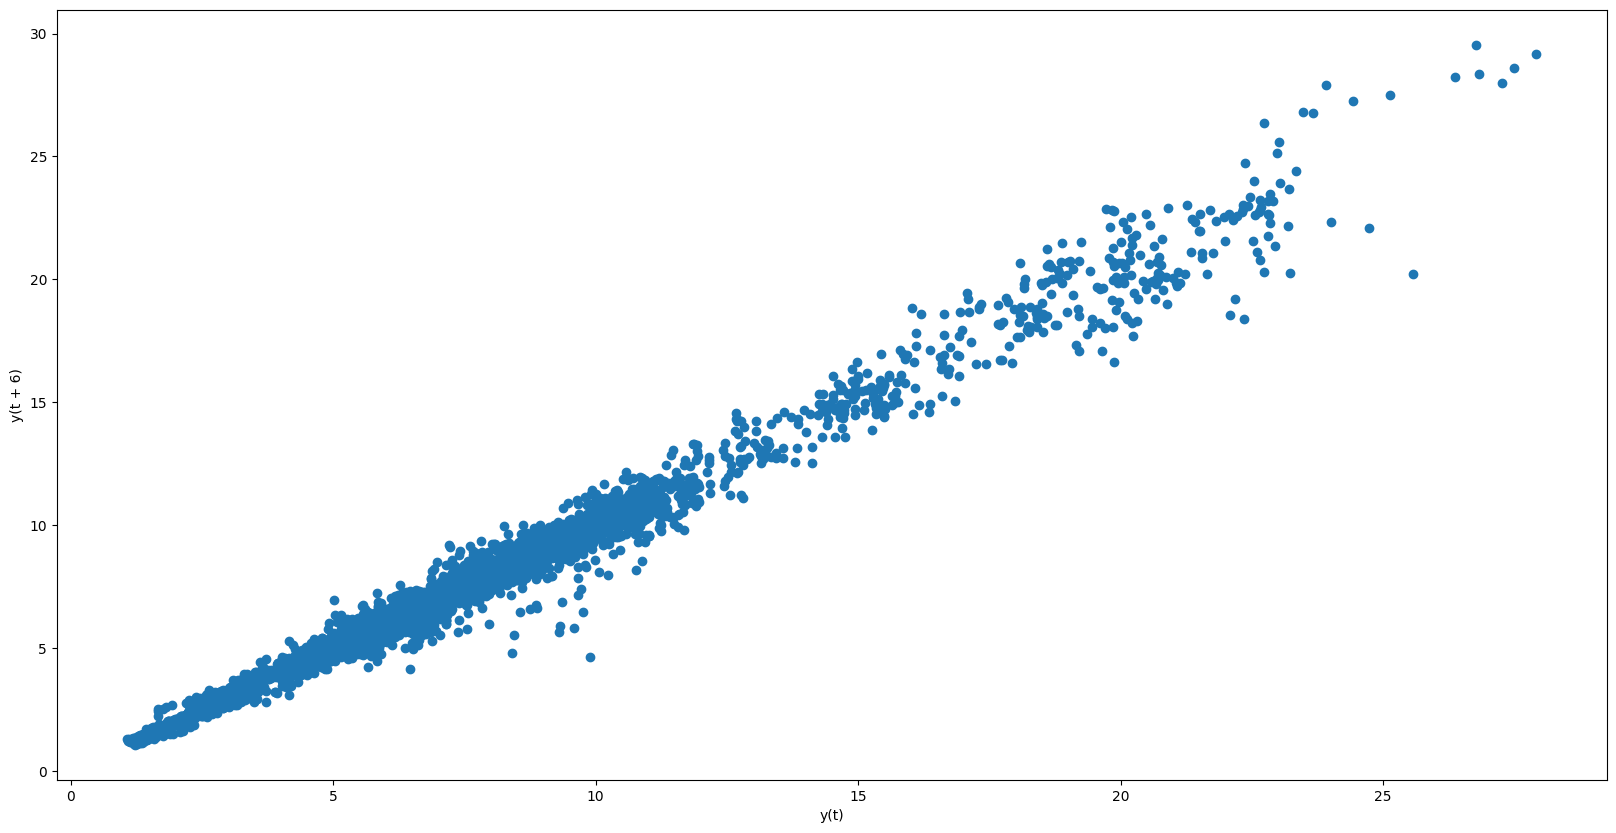

In [29]:
pd.plotting.lag_plot(petro_prices['petro_close'], lag = 6)

<Axes: xlabel='y(t)', ylabel='y(t + 10)'>

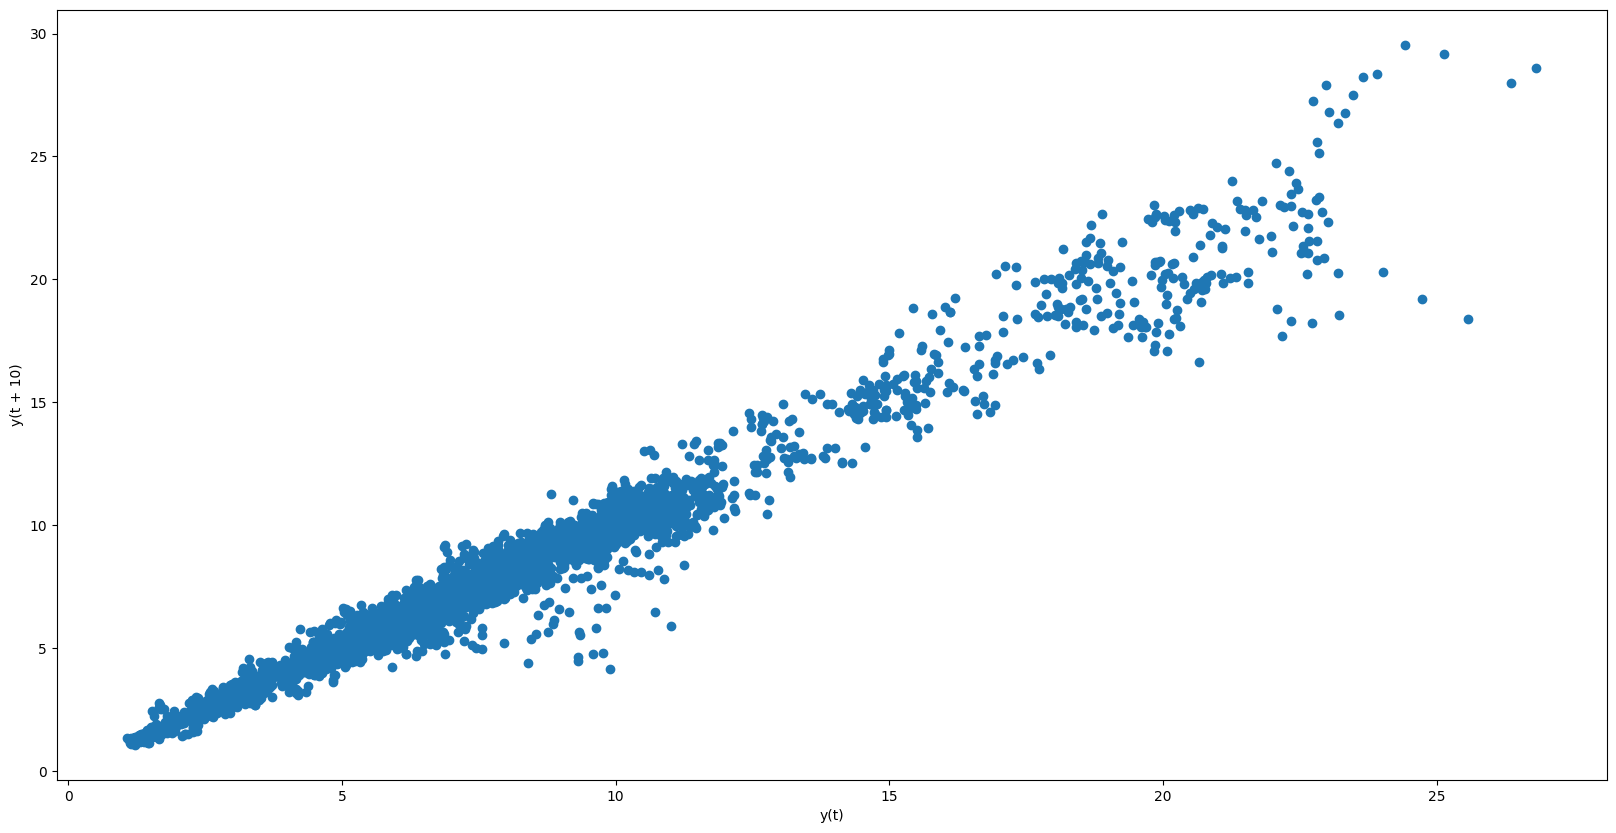

In [30]:
pd.plotting.lag_plot(petro_prices['petro_close'], lag = 10)

<Axes: xlabel='y(t)', ylabel='y(t + 20)'>

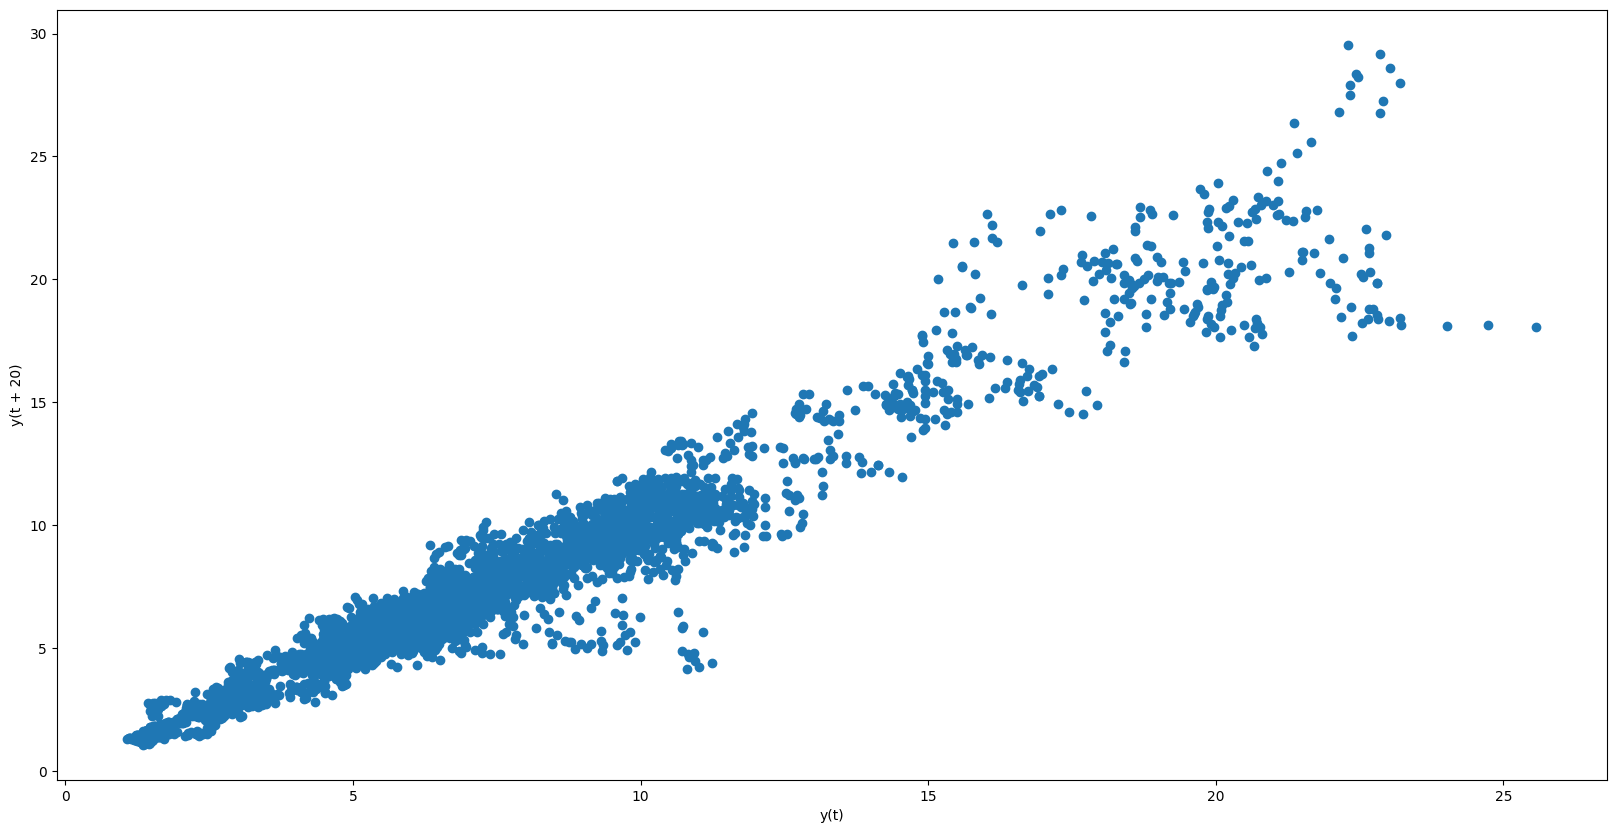

In [31]:
pd.plotting.lag_plot(petro_prices['petro_close'], lag = 20)

<Axes: xlabel='y(t)', ylabel='y(t + 50)'>

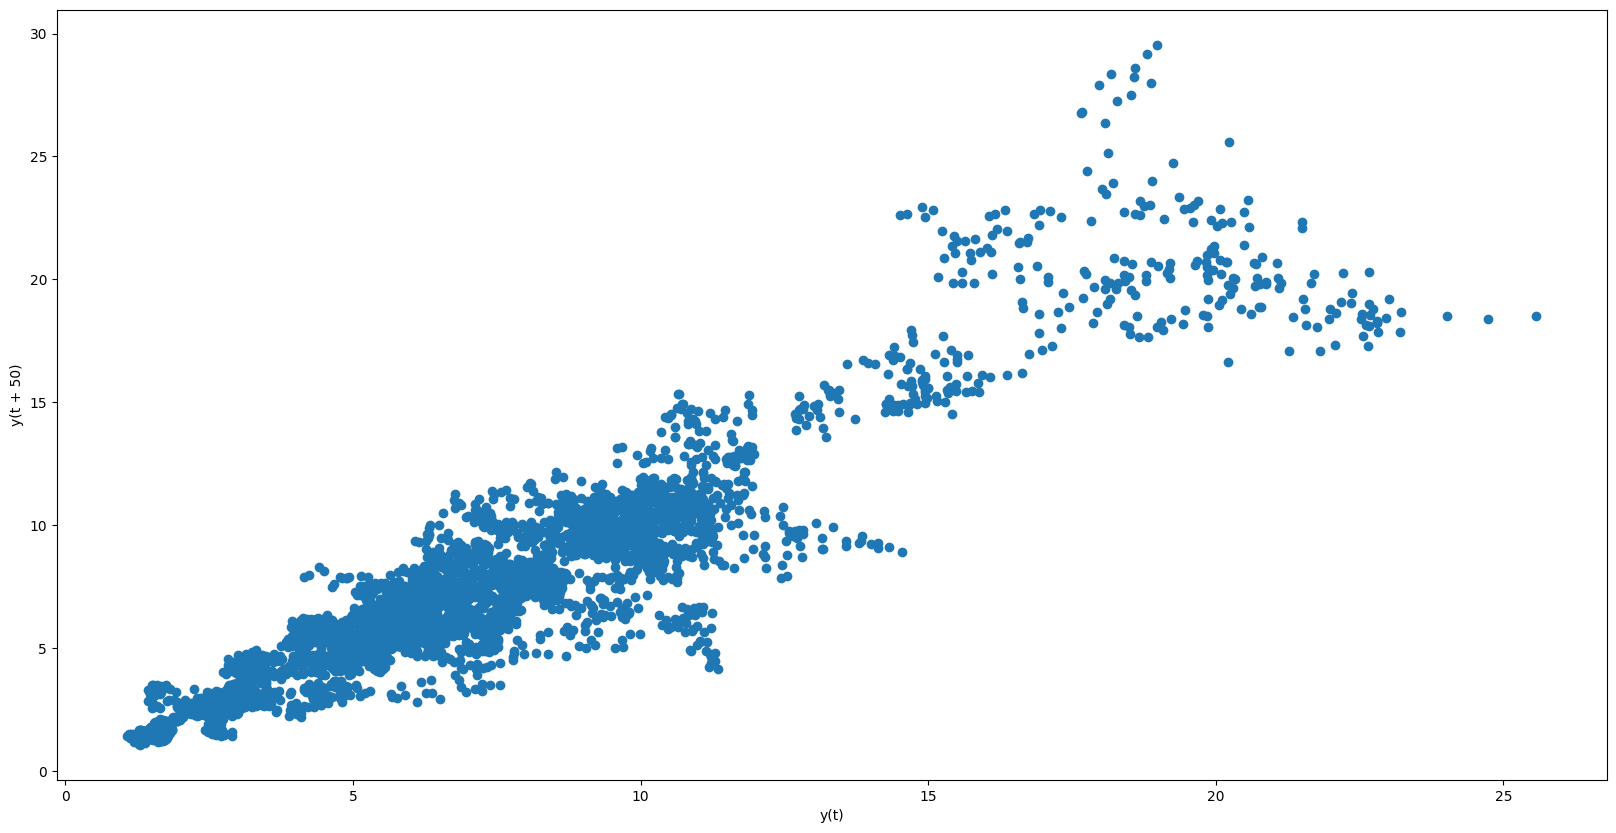

In [32]:
pd.plotting.lag_plot(petro_prices['petro_close'], lag = 50)

## Autocorrelation

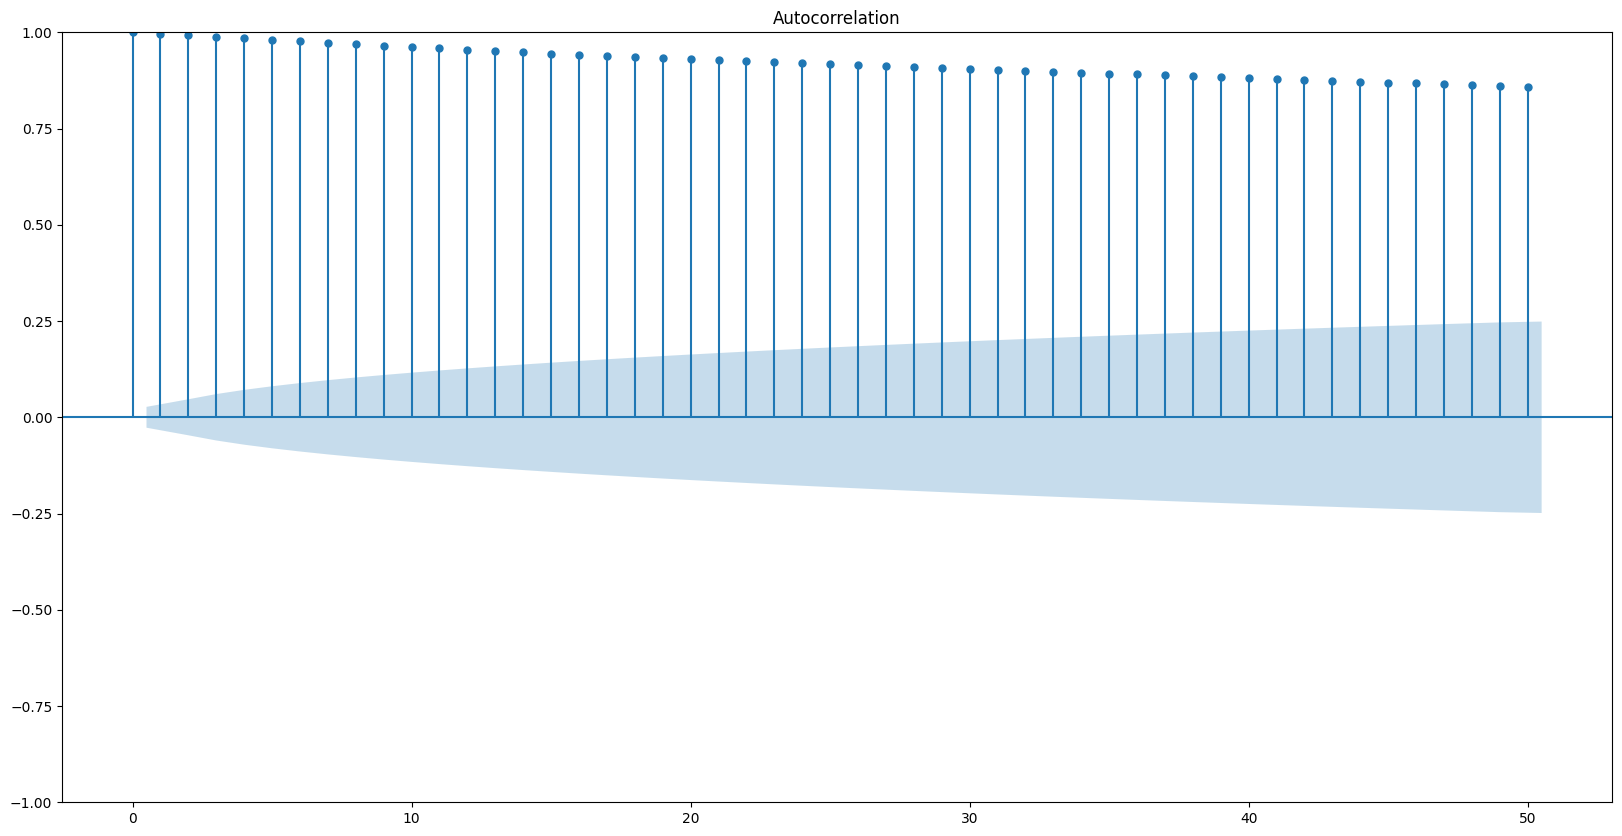

In [33]:
plot_acf(petro_prices['petro_close'], lags=50)
plt.show()

## Simple methods for forecasting

### The mean method

In [34]:
petro_mean = petro_prices['petro_close'].mean()

In [35]:
petro_mean

6.969321135187632

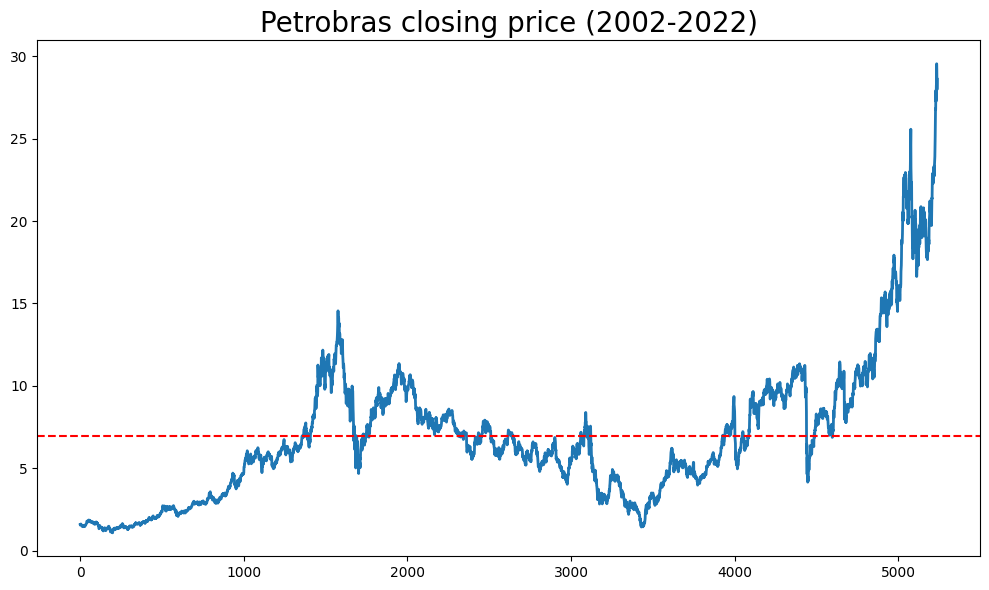

In [36]:
fig, ax = plt.subplots(figsize=(10, 6))
petro_prices['petro_close'].plot(kind='line', ax=ax, linewidth=2)
plt.axhline(petro_mean, color = 'r', linestyle = '--') 
ax.set_title('Petrobras closing price (2002-2022)', fontsize=20)
plt.tight_layout()

### Naive method

For naive forecasts, we simply set all forecasts to be the value of the last observation

In [37]:
len(petro_prices)

5239

In [38]:
X = petro_prices.iloc[:round(0.8*len(petro_prices))]
y = petro_prices.iloc[round(0.8*(len(petro_prices))):]

In [39]:
y_hat = y.copy()
y_hat['naive'] = X['petro_close'].iloc[-1]

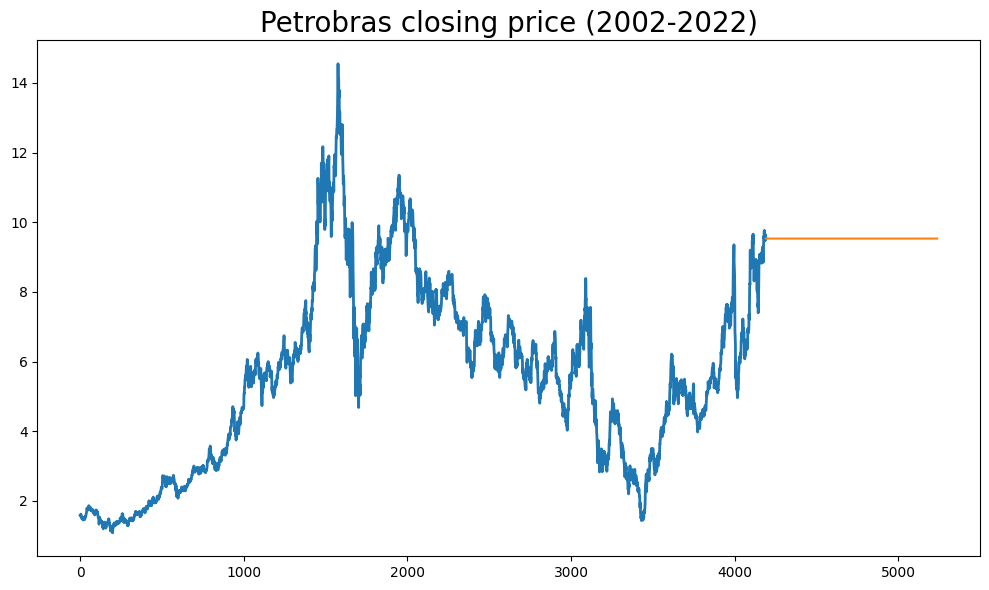

In [40]:
fig, ax = plt.subplots(figsize=(10, 6))
X['petro_close'].plot(kind='line', ax=ax, linewidth=2)
y_hat['naive'].plot(kind='line', ax=ax)
ax.set_title('Petrobras closing price (2002-2022)', fontsize=20)
plt.tight_layout()

## RESIDUALS

In [41]:
residuals = y['petro_close'] - y['petro_close'].shift(1)

In [42]:
residuals

4191         NaN
4192   -0.035622
4193    0.384702
4194   -0.089050
4195    0.213722
          ...   
5234    0.139145
5235    1.187378
5236   -0.371058
5237   -1.196653
5238    0.630795
Name: petro_close, Length: 1048, dtype: float64

<Axes: >

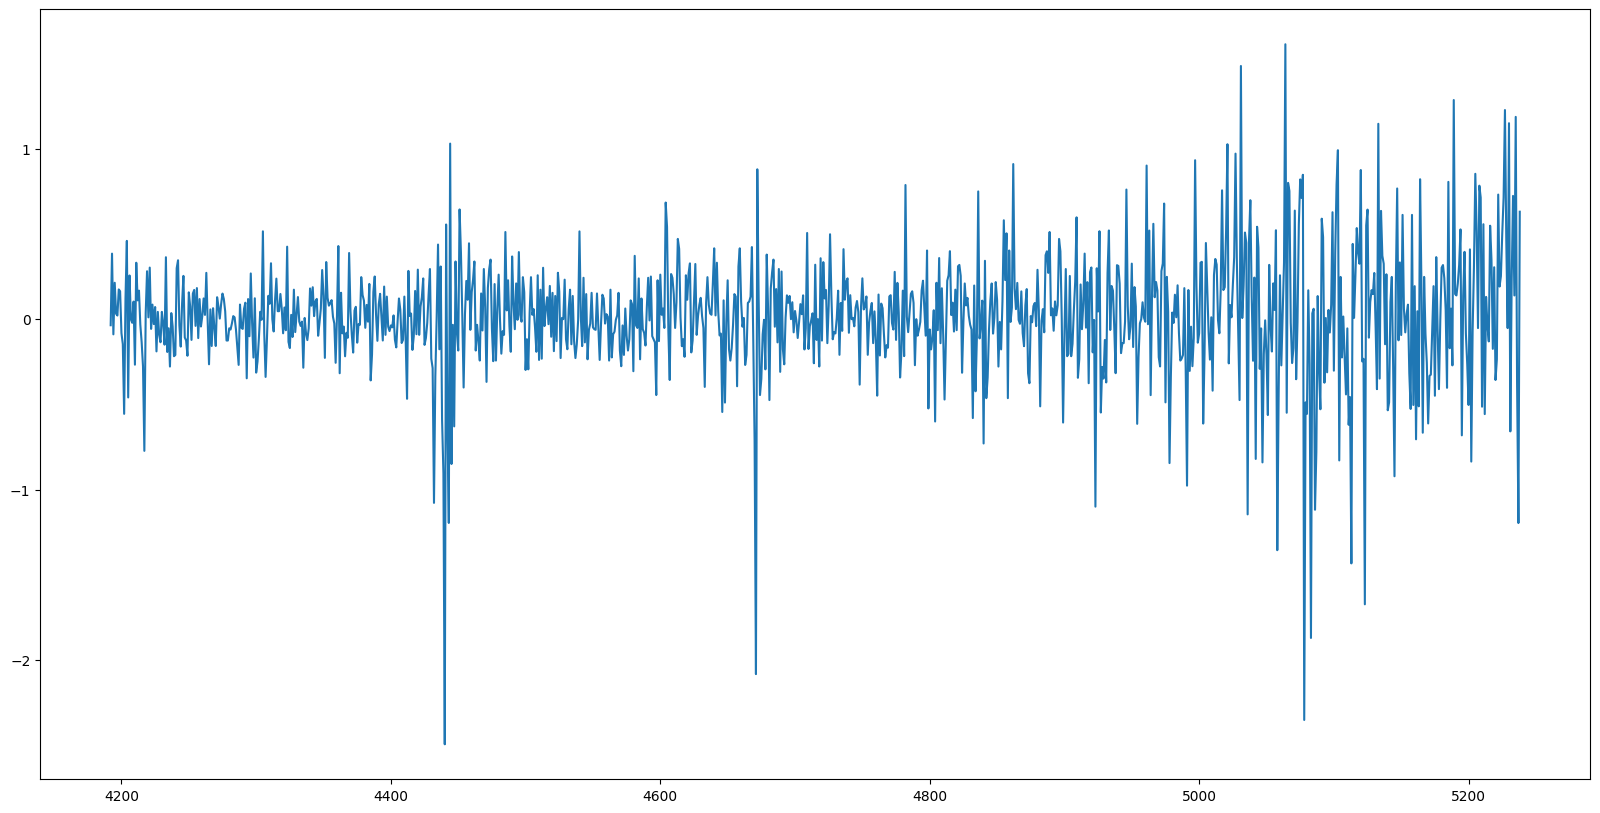

In [43]:
residuals.plot()

<Axes: >

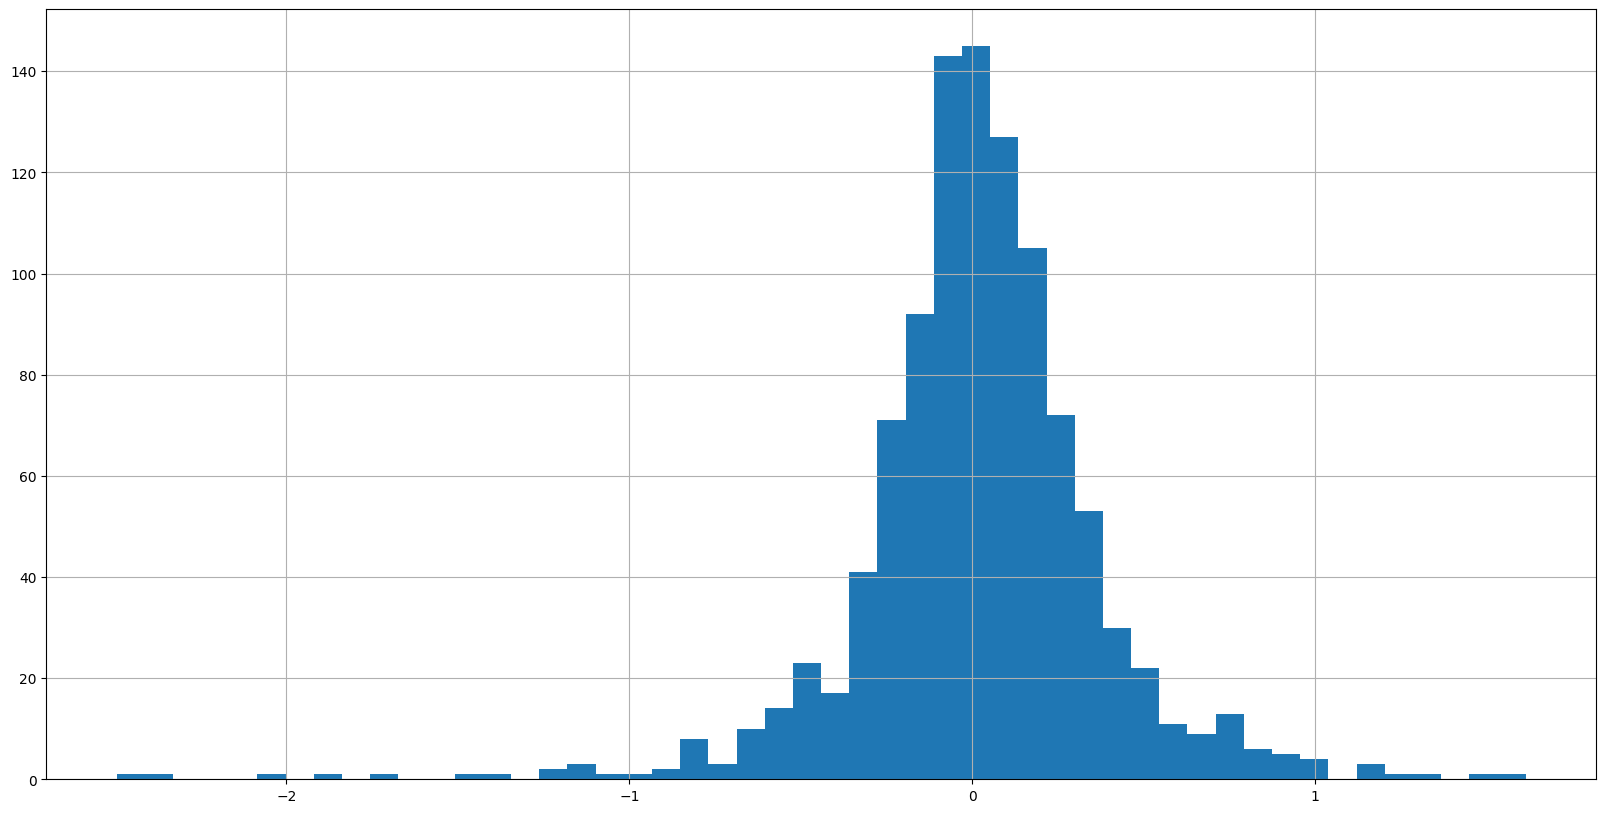

In [44]:
residuals.hist(bins=50)

### Correlation among variables 

In [45]:
petro_prices

Date  petro_close  Exchange_rate  Selic  Oil_price
0    2001-12-31     1.578670          2.320  19.00      19.35
1    2002-01-02     1.581756          2.306  19.00      20.13
2    2002-01-03     1.592558          2.292  19.00      20.47
3    2002-01-04     1.582682          2.309  19.00      21.20
4    2002-01-07     1.617249          2.342  19.00      21.08
...         ...          ...            ...    ...        ...
5234 2023-06-20    28.357922          4.792  13.75      75.79
5235 2023-06-21    29.545300          4.779  13.75      76.92
5236 2023-06-22    29.174242          4.774  13.75      73.93
5237 2023-06-23    27.977589          4.779  13.75      73.56
5238 2023-06-26    28.608383          4.769  13.75      73.86

[5239 rows x 5 columns]

In [46]:
def add_lags(dataset, column_list, n_lags): 
    for column in column_list:
        for lag in range(1, n_lags+1): 
            dataset[column, lag] = dataset[column].shift(lag)
    return dataset

In [47]:
petro_prices_lag = add_lags(petro_prices, column_list = ['Exchange_rate', 'Selic', 'Oil_price'], n_lags = 1500)

C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[column, lag] = dataset[column].shift(lag)
C:\Users\caiol\AppData\Local\Temp\ipykernel_9720\1872267892.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

In [48]:
petro_prices_lag.columns

Index([              'Date',        'petro_close',      'Exchange_rate',
                    'Selic',          'Oil_price', ('Exchange_rate', 1),
       ('Exchange_rate', 2), ('Exchange_rate', 3), ('Exchange_rate', 4),
       ('Exchange_rate', 5),
       ...
        ('Oil_price', 1491),  ('Oil_price', 1492),  ('Oil_price', 1493),
        ('Oil_price', 1494),  ('Oil_price', 1495),  ('Oil_price', 1496),
        ('Oil_price', 1497),  ('Oil_price', 1498),  ('Oil_price', 1499),
        ('Oil_price', 1500)],
      dtype='object', length=4505)

In [49]:
petro_prices.index = petro_prices['Date']

In [50]:
petro_prices = petro_prices.drop('Date', axis=1)

In [51]:
petro_prices = petro_prices.dropna()

In [52]:
corr = petro_prices.corr()

In [53]:
price_corr = corr['petro_close']

In [54]:
price_corr = pd.Series(price_corr)

In [55]:
for i, v in price_corr.items():
    if 'Exchange_rate' in i:
        print(i)

Exchange_rate
('Exchange_rate', 1)
('Exchange_rate', 2)
('Exchange_rate', 3)
('Exchange_rate', 4)
('Exchange_rate', 5)
('Exchange_rate', 6)
('Exchange_rate', 7)
('Exchange_rate', 8)
('Exchange_rate', 9)
('Exchange_rate', 10)
('Exchange_rate', 11)
('Exchange_rate', 12)
('Exchange_rate', 13)
('Exchange_rate', 14)
('Exchange_rate', 15)
('Exchange_rate', 16)
('Exchange_rate', 17)
('Exchange_rate', 18)
('Exchange_rate', 19)
('Exchange_rate', 20)
('Exchange_rate', 21)
('Exchange_rate', 22)
('Exchange_rate', 23)
('Exchange_rate', 24)
('Exchange_rate', 25)
('Exchange_rate', 26)
('Exchange_rate', 27)
('Exchange_rate', 28)
('Exchange_rate', 29)
('Exchange_rate', 30)
('Exchange_rate', 31)
('Exchange_rate', 32)
('Exchange_rate', 33)
('Exchange_rate', 34)
('Exchange_rate', 35)
('Exchange_rate', 36)
('Exchange_rate', 37)
('Exchange_rate', 38)
('Exchange_rate', 39)
('Exchange_rate', 40)
('Exchange_rate', 41)
('Exchange_rate', 42)
('Exchange_rate', 43)
('Exchange_rate', 44)
('Exchange_rate', 45)
('Exc

('Exchange_rate', 430)
('Exchange_rate', 431)
('Exchange_rate', 432)
('Exchange_rate', 433)
('Exchange_rate', 434)
('Exchange_rate', 435)
('Exchange_rate', 436)
('Exchange_rate', 437)
('Exchange_rate', 438)
('Exchange_rate', 439)
('Exchange_rate', 440)
('Exchange_rate', 441)
('Exchange_rate', 442)
('Exchange_rate', 443)
('Exchange_rate', 444)
('Exchange_rate', 445)
('Exchange_rate', 446)
('Exchange_rate', 447)
('Exchange_rate', 448)
('Exchange_rate', 449)
('Exchange_rate', 450)
('Exchange_rate', 451)
('Exchange_rate', 452)
('Exchange_rate', 453)
('Exchange_rate', 454)
('Exchange_rate', 455)
('Exchange_rate', 456)
('Exchange_rate', 457)
('Exchange_rate', 458)
('Exchange_rate', 459)
('Exchange_rate', 460)
('Exchange_rate', 461)
('Exchange_rate', 462)
('Exchange_rate', 463)
('Exchange_rate', 464)
('Exchange_rate', 465)
('Exchange_rate', 466)
('Exchange_rate', 467)
('Exchange_rate', 468)
('Exchange_rate', 469)
('Exchange_rate', 470)
('Exchange_rate', 471)
('Exchange_rate', 472)
('Exchange_

In [56]:
exchange_rate = []
selic = []
oil_price = []
for i, v in price_corr.items():
    if 'Exchange_rate' in i:
        exchange_rate.append(v)
    if 'Selic' in i:
        selic.append(v)
    if 'Oil_price' in i: 
        oil_price.append(v)

In [57]:
price_corr

petro_close           1.000000
Exchange_rate         0.418109
Selic                 0.002974
Oil_price             0.265682
(Exchange_rate, 1)    0.419103
                        ...   
(Oil_price, 1496)    -0.314006
(Oil_price, 1497)    -0.313532
(Oil_price, 1498)    -0.313095
(Oil_price, 1499)    -0.312729
(Oil_price, 1500)    -0.312345
Name: petro_close, Length: 4504, dtype: float64

In [58]:
selic

[0.002974107967626066,
 0.001795859693781772,
 0.000600454008170427,
 -0.0005956461603352085,
 -0.00175443824691167,
 -0.002912493384377423,
 -0.004067806462799541,
 -0.005278679613725505,
 -0.0064612459884013105,
 -0.007631631013145205,
 -0.008817773012852363,
 -0.010031382916570443,
 -0.011242718959748226,
 -0.012465199086608253,
 -0.01370058517543653,
 -0.014948999308119132,
 -0.016168601040516005,
 -0.01739619745492531,
 -0.018603884931287104,
 -0.01982866603359954,
 -0.021016607921711034,
 -0.02219623676693593,
 -0.023406060840120077,
 -0.024640624969689537,
 -0.025901926113208983,
 -0.027143108192961767,
 -0.02836645230751342,
 -0.029590434052756506,
 -0.030795518632726386,
 -0.03196443817416669,
 -0.033119503181593464,
 -0.03433080918505585,
 -0.03550039499216983,
 -0.03666861547979987,
 -0.03782700405614322,
 -0.038978554584195836,
 -0.040135763863260655,
 -0.04131177974628888,
 -0.042503661630269154,
 -0.043679071422212785,
 -0.04484908157835357,
 -0.04605427940844681,
 -0.047

In [59]:
exchange_rate

[0.4181093625202531,
 0.41910323010058653,
 0.42006212174217994,
 0.42106884866326194,
 0.42209689597500594,
 0.423124991712927,
 0.42413975016045813,
 0.4250866844112978,
 0.4261030944248956,
 0.42710534691415897,
 0.4280985605027336,
 0.42908742573212205,
 0.43010008991338927,
 0.4311109451168265,
 0.43207767639910327,
 0.43298737373004403,
 0.4339081824912477,
 0.4347747940590319,
 0.43556570154722724,
 0.43639346782956695,
 0.4373059945908384,
 0.43824073001022196,
 0.4392275748285803,
 0.4401759825151309,
 0.44107703389863984,
 0.4419755357863694,
 0.4429357288362823,
 0.44392178369821206,
 0.44495785083291844,
 0.4459819493463624,
 0.44700050208698067,
 0.44793609801756573,
 0.44887866390210374,
 0.44974965036101605,
 0.45065788623164343,
 0.45152148115689145,
 0.4524111289962578,
 0.4533349748012262,
 0.45423851685337746,
 0.4551652257337761,
 0.45601389049043817,
 0.4568417425272691,
 0.4576522628662792,
 0.4584507748859372,
 0.4592394529269437,
 0.460107396934747,
 0.460954391

In [60]:
oil_price

[0.2656820585325966,
 0.26439283817282044,
 0.2631668813471926,
 0.26191799349472783,
 0.2606885880571422,
 0.25938557191820955,
 0.25808966411219336,
 0.2567345026591869,
 0.2554904360647931,
 0.25443279651318534,
 0.2534159944006809,
 0.2525528786884092,
 0.25155182343538923,
 0.2505285495589117,
 0.2495985888461435,
 0.24858814900076343,
 0.2475105063085948,
 0.24641050210735774,
 0.2454364371975822,
 0.24447560758362527,
 0.24337548503089076,
 0.24234727406484413,
 0.241242882557555,
 0.24026350232992044,
 0.2393285675236942,
 0.23837958764051997,
 0.2374230540665711,
 0.2363042992250746,
 0.23534538274544342,
 0.23436788623368124,
 0.23343708228307836,
 0.23251547923861815,
 0.2315831378201387,
 0.23064681669840387,
 0.2297926132809332,
 0.22908218073974584,
 0.228408763149973,
 0.22757895167743594,
 0.22650273505231824,
 0.2254128752685857,
 0.22429639041670535,
 0.22314778963375165,
 0.2217976732253627,
 0.2204795856039815,
 0.2189332461117189,
 0.21752247315030251,
 0.216100478

In [61]:
lags = []
for i in range(0, 1501):
    lags.append(f"lag_{i}")

In [62]:
lags

['lag_0',
 'lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7',
 'lag_8',
 'lag_9',
 'lag_10',
 'lag_11',
 'lag_12',
 'lag_13',
 'lag_14',
 'lag_15',
 'lag_16',
 'lag_17',
 'lag_18',
 'lag_19',
 'lag_20',
 'lag_21',
 'lag_22',
 'lag_23',
 'lag_24',
 'lag_25',
 'lag_26',
 'lag_27',
 'lag_28',
 'lag_29',
 'lag_30',
 'lag_31',
 'lag_32',
 'lag_33',
 'lag_34',
 'lag_35',
 'lag_36',
 'lag_37',
 'lag_38',
 'lag_39',
 'lag_40',
 'lag_41',
 'lag_42',
 'lag_43',
 'lag_44',
 'lag_45',
 'lag_46',
 'lag_47',
 'lag_48',
 'lag_49',
 'lag_50',
 'lag_51',
 'lag_52',
 'lag_53',
 'lag_54',
 'lag_55',
 'lag_56',
 'lag_57',
 'lag_58',
 'lag_59',
 'lag_60',
 'lag_61',
 'lag_62',
 'lag_63',
 'lag_64',
 'lag_65',
 'lag_66',
 'lag_67',
 'lag_68',
 'lag_69',
 'lag_70',
 'lag_71',
 'lag_72',
 'lag_73',
 'lag_74',
 'lag_75',
 'lag_76',
 'lag_77',
 'lag_78',
 'lag_79',
 'lag_80',
 'lag_81',
 'lag_82',
 'lag_83',
 'lag_84',
 'lag_85',
 'lag_86',
 'lag_87',
 'lag_88',
 'lag_89',
 'lag_90',
 'lag_91'

In [63]:
corr_matrix = pd.DataFrame({'Selic': selic, 'Oil_price': oil_price, 'Exchange_rate': exchange_rate},
                          index = lags)

In [64]:
corr_matrix.head(50)

Selic  Oil_price  Exchange_rate
lag_0   0.002974   0.265682       0.418109
lag_1   0.001796   0.264393       0.419103
lag_2   0.000600   0.263167       0.420062
lag_3  -0.000596   0.261918       0.421069
lag_4  -0.001754   0.260689       0.422097
lag_5  -0.002912   0.259386       0.423125
lag_6  -0.004068   0.258090       0.424140
lag_7  -0.005279   0.256735       0.425087
lag_8  -0.006461   0.255490       0.426103
lag_9  -0.007632   0.254433       0.427105
lag_10 -0.008818   0.253416       0.428099
lag_11 -0.010031   0.252553       0.429087
lag_12 -0.011243   0.251552       0.430100
lag_13 -0.012465   0.250529       0.431111
lag_14 -0.013701   0.249599       0.432078
lag_15 -0.014949   0.248588       0.432987
lag_16 -0.016169   0.247511       0.433908
lag_17 -0.017396   0.246411       0.434775
lag_18 -0.018604   0.245436       0.435566
lag_19 -0.019829   0.244476       0.436393
lag_20 -0.021017   0.243375       0.437306
lag_21 -0.022196   0.242347       0.438241
lag_22 -0.023406   0.241243       0.439228
lag_23 -0.024641   0.240264       0.440176
lag_24 -0.025902   0.239329       0.441077
lag_25 -0.027143   0.238380       0.441976
lag_26 -0.028366   0.237423       0.442936
lag_27 -0.029590   0.236304       0.443922
lag_28 -0.030796   0.235345       0.444958
lag_29 -0.031964   0.234368       0.445982
lag_30 -0.033120   0.233437       0.447001
lag_31 -0.034331   0.232515       0.447936
lag_32 -0.035500   0.231583       0.448879
lag_33 -0.036669   0.230647       0.449750
lag_34 -0.037827   0.229793       0.450658
lag_35 -0.038979   0.229082       0.451521
lag_36 -0.040136   0.228409       0.452411
lag_37 -0.041312   0.227579       0.453335
lag_38 -0.042504   0.226503       0.454239
lag_39 -0.043679   0.225413       0.455165
lag_40 -0.044849   0.224296       0.456014
lag_41 -0.046054   0.223148       0.456842
lag_42 -0.047276   0.221798       0.457652
lag_43 -0.048536   0.220480       0.458451
lag_44 -0.049823   0.218933       0.459239
lag_45 -0.051107   0.217522       0.460107
lag_46 -0.052421   0.216100       0.460954
lag_47 -0.053709   0.214477       0.461787
lag_48 -0.055037   0.212911       0.462650
lag_49 -0.056370   0.211356       0.463450

<Axes: >

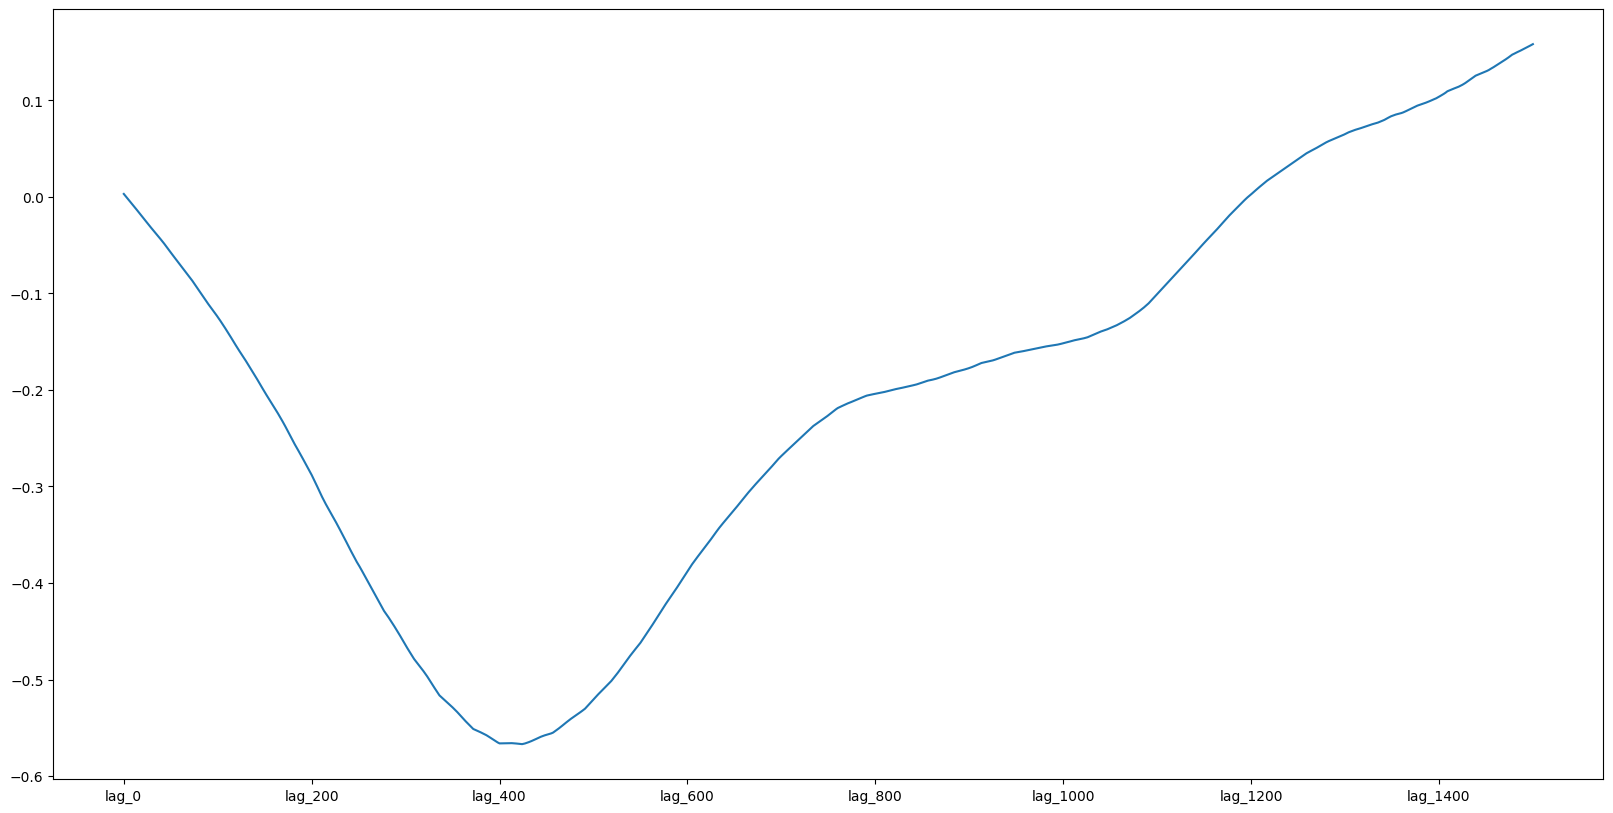

In [65]:
corr_matrix['Selic'].plot()

<Axes: >

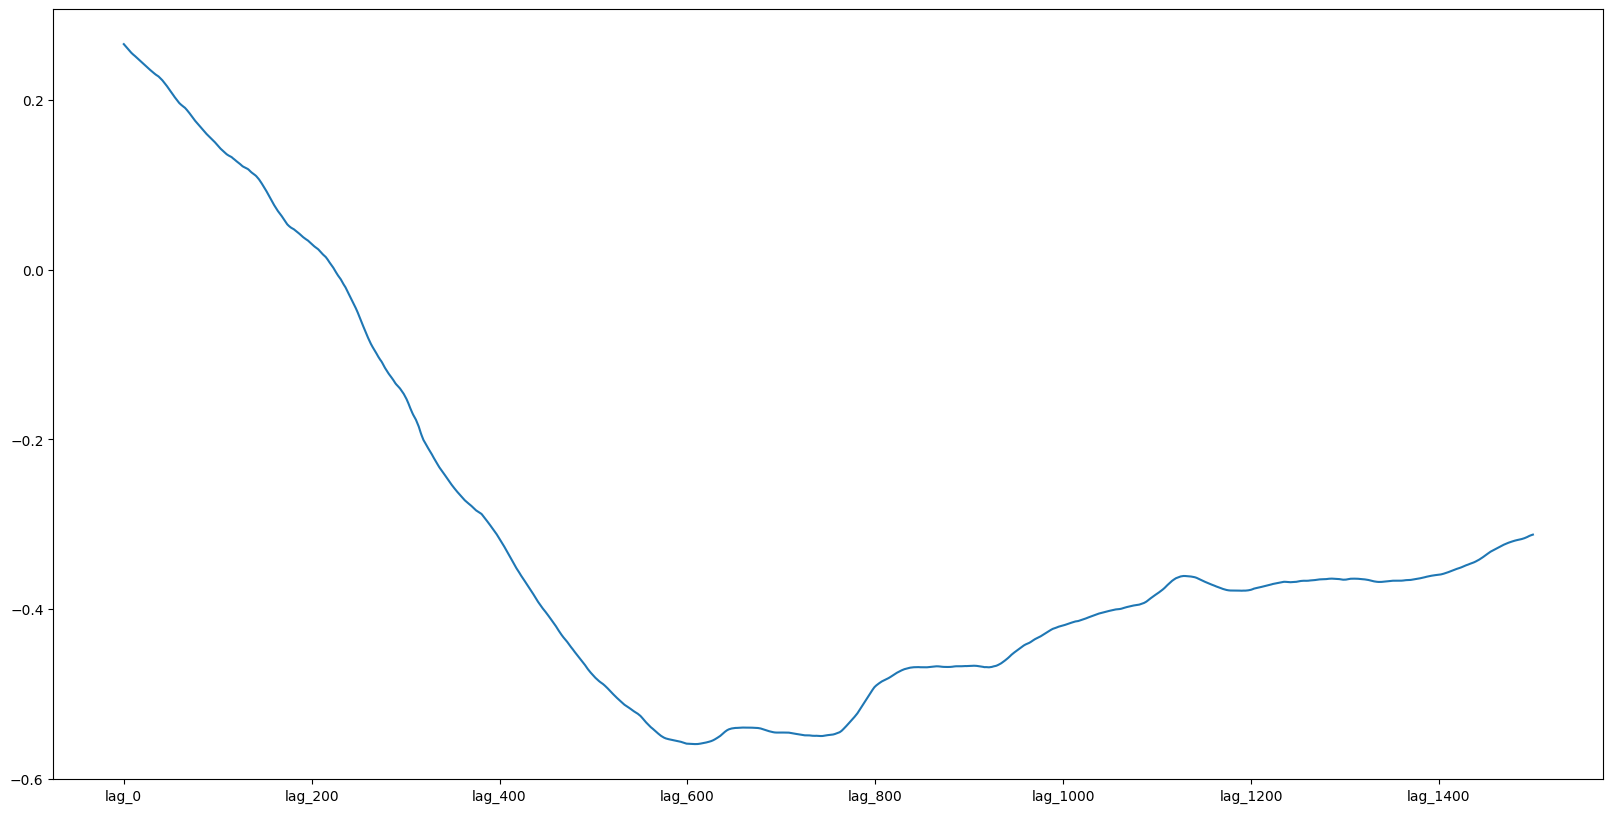

In [66]:
corr_matrix['Oil_price'].plot()

<Axes: >

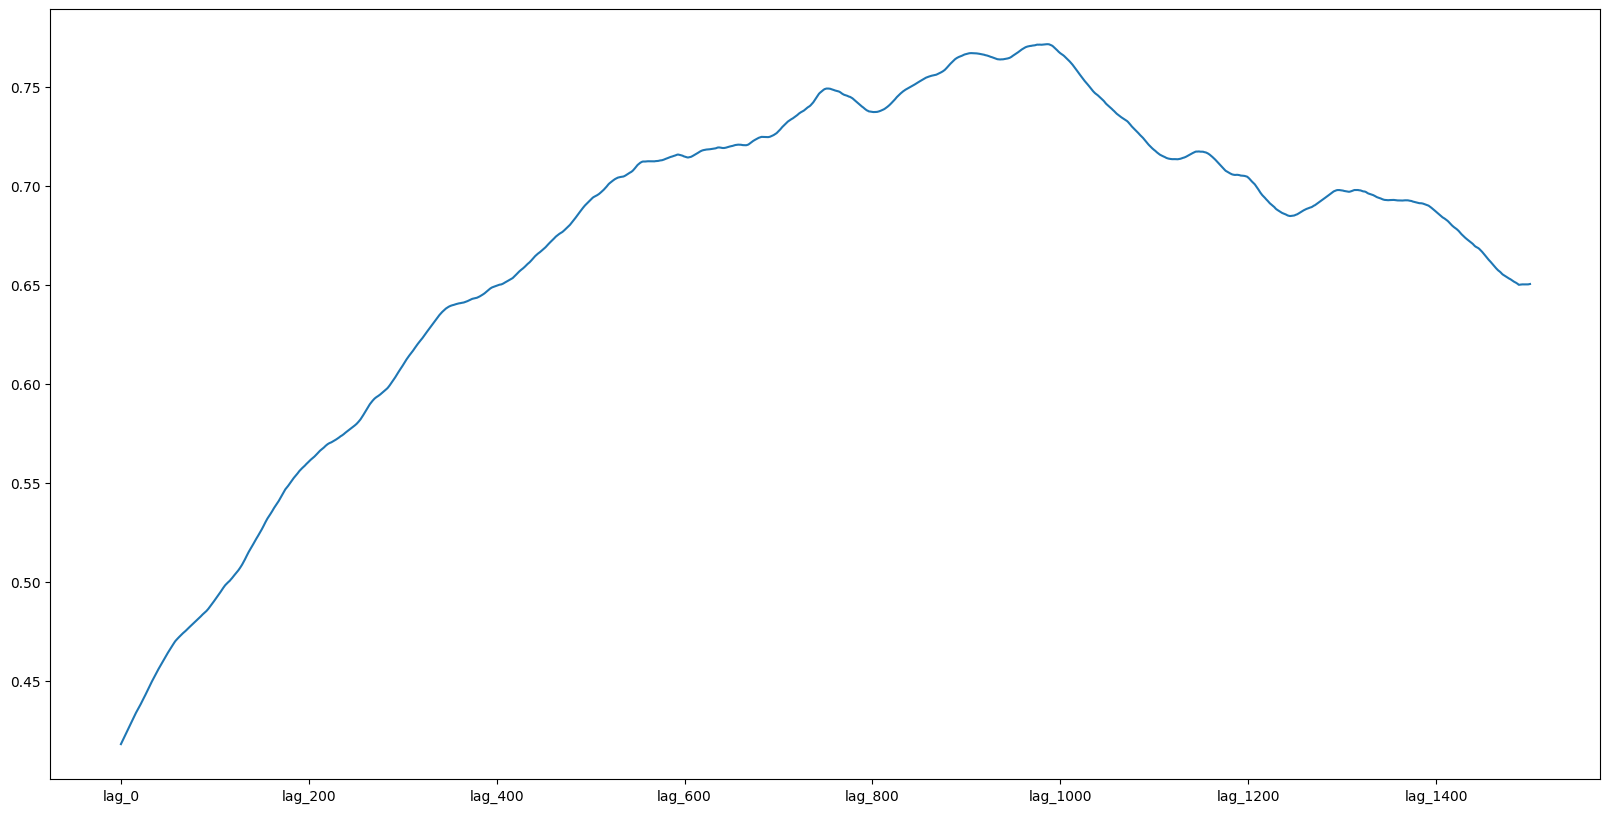

In [67]:
corr_matrix['Exchange_rate'].plot()

## Building a AR model


### Checking for stationarity

In [68]:
stock = Ticker("PETR4.SA")
stock = stock.history(period="max")
petro_prices = stock['close']
petro_prices = pd.DataFrame(petro_prices, columns =['close'])

petro_prices['petro_close'] = petro_prices['close']
petro_prices = petro_prices.drop('close', axis=1)

petro_prices = correct_multindex(petro_prices, level=[0, 1], column_exclusion = 'symbol')
petro_prices = convert_datatypes(petro_prices, column_to_numeric = 'petro_close', column_to_date='date')
petro_prices = petro_prices.rename(columns={"date": "Date", "close": "petro_close"})

In [69]:
from statsmodels.tsa.stattools import adfuller

In [70]:
petro_prices.head()

Date  petro_close
0 2000-01-03        5.875
1 2000-01-04        5.550
2 2000-01-05        5.494
3 2000-01-06        5.475
4 2000-01-07        5.500

In [71]:
ADF_result = adfuller(petro_prices['petro_close'])

In [72]:
print(f"ADF Statistics: {ADF_result[0]}")
print(f"p-value: {ADF_result[1]}")

ADF Statistics: -2.058995721545157
p-value: 0.26131889929105667


In [73]:
petro_prices_diff = np.diff(petro_prices['petro_close'], n=1) 

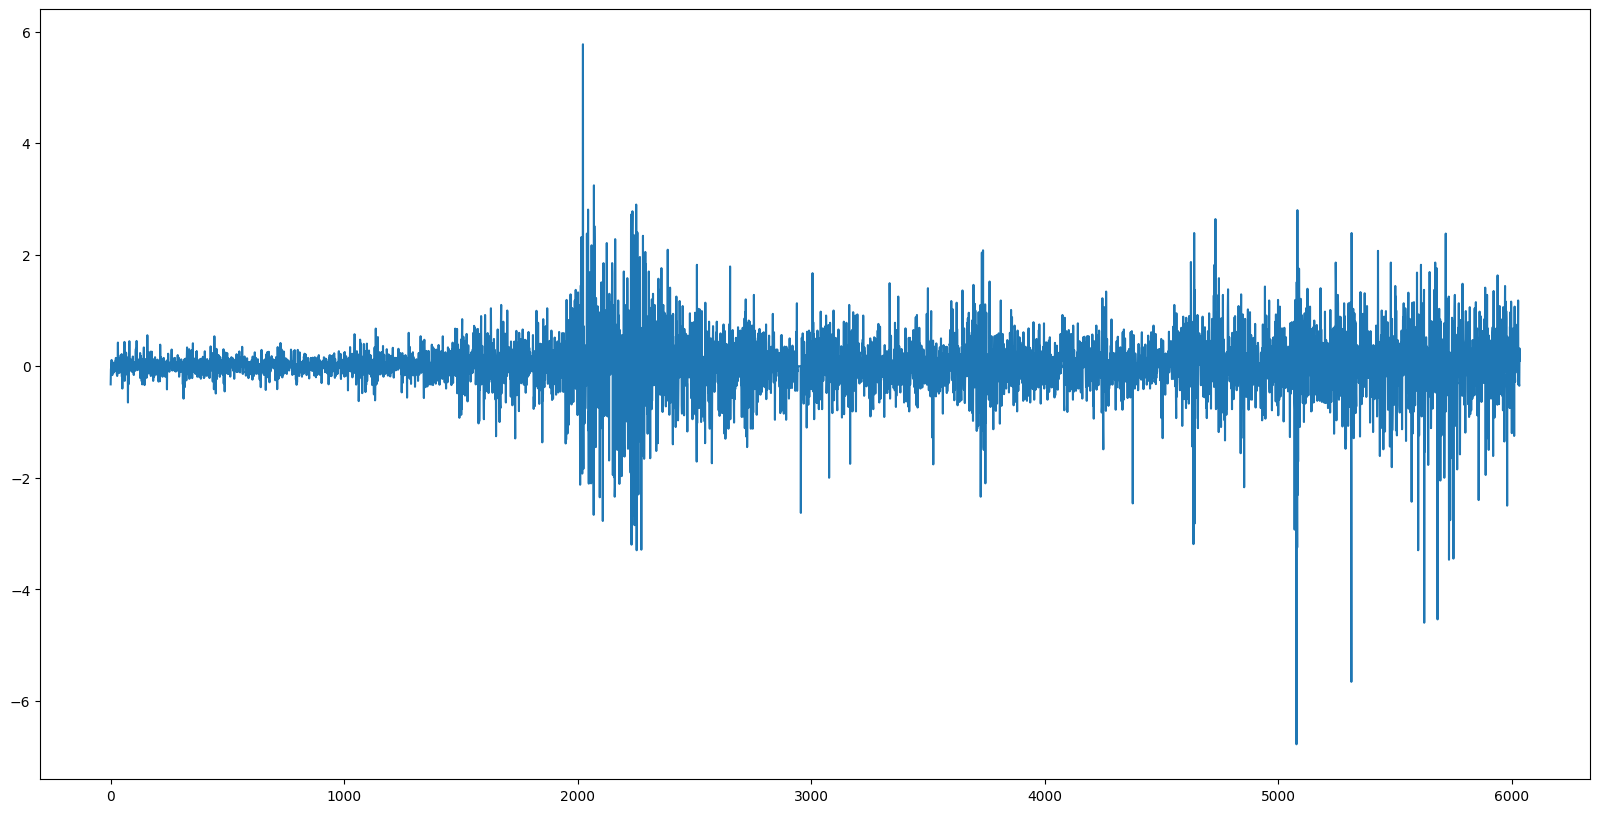

In [74]:
plt.plot(petro_prices_diff)

In [75]:
ADF_result = adfuller(petro_prices_diff)

In [76]:
print(f"ADF Statistics: {ADF_result[0]}")
print(f"p-value: {ADF_result[1]}")

ADF Statistics: -13.151090421301452
p-value: 1.3665120854443416e-24


The series is now stationary

### Autocorrelation

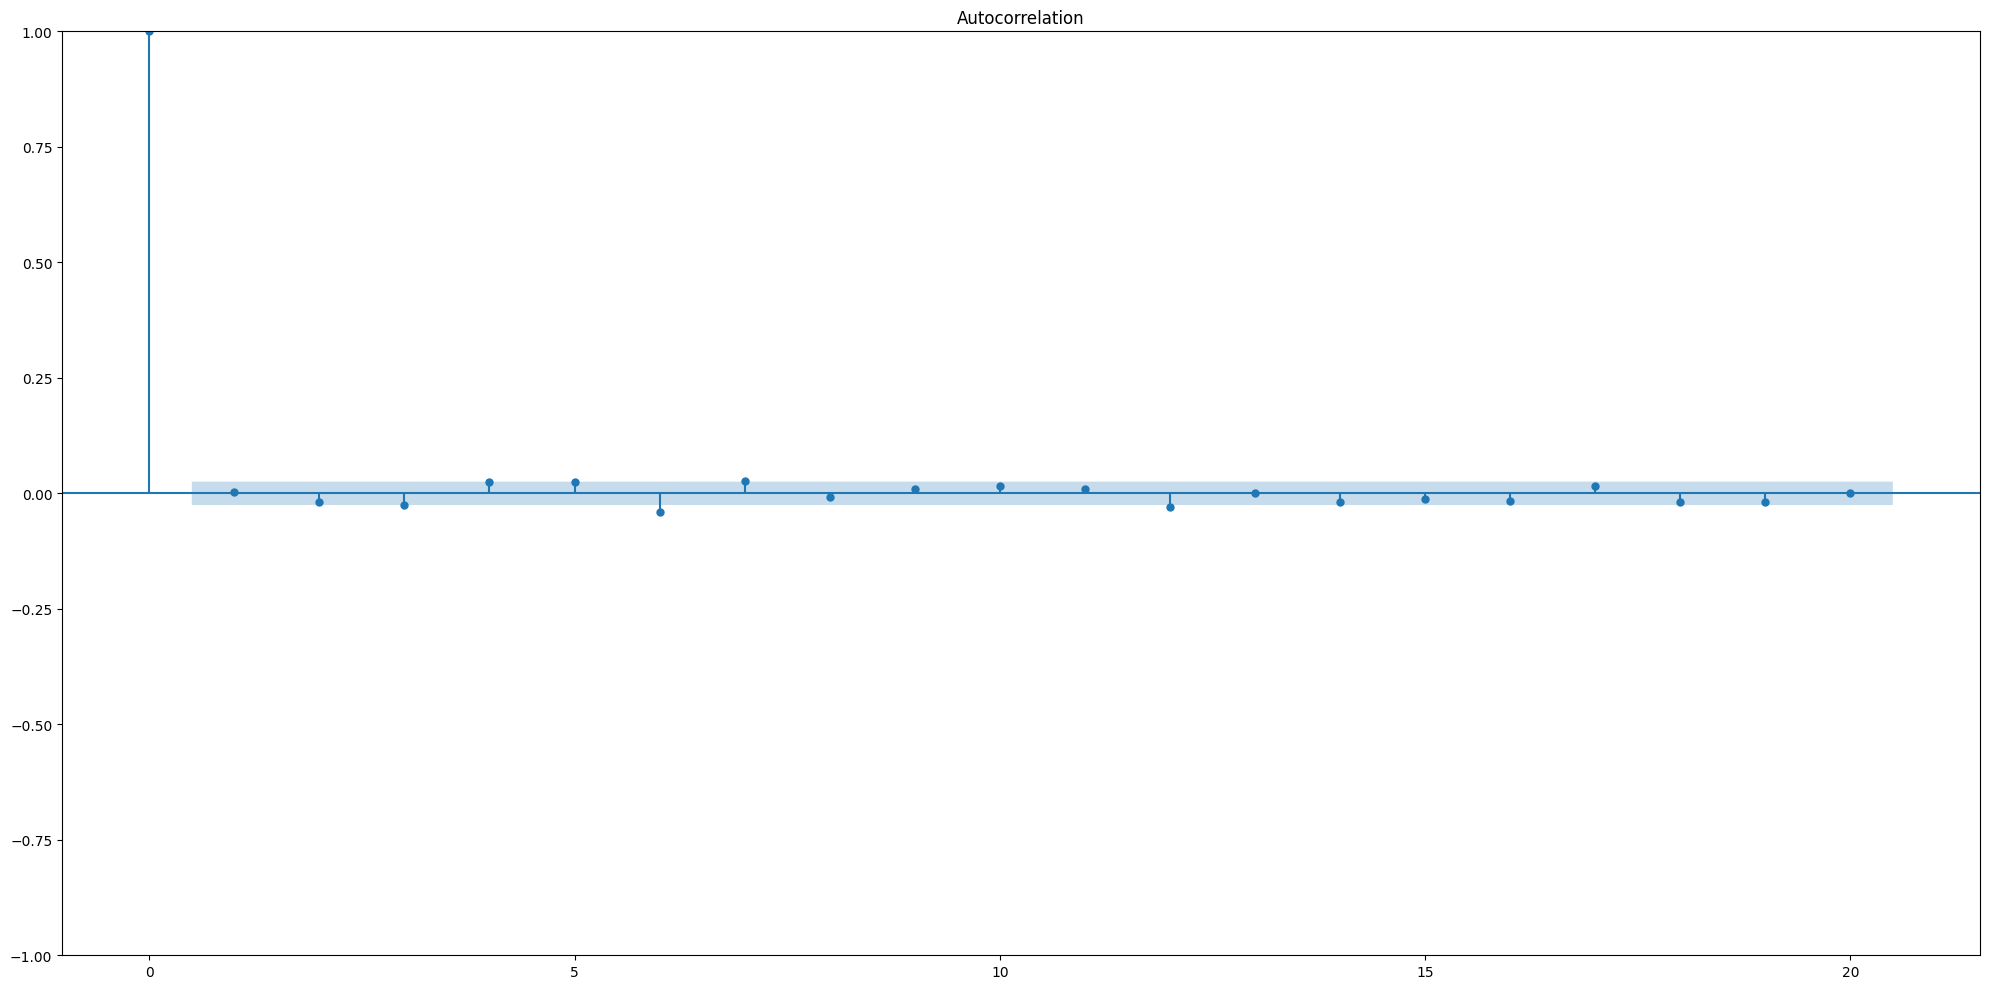

In [77]:
plot_acf(petro_prices_diff, lags=20);
plt.tight_layout()

In [78]:
prices_diff = pd.DataFrame({'petro_prices_diff': petro_prices_diff})

In [79]:
train = prices_diff.iloc[:round(len(prices_diff) * 0.8)]
test = prices_diff.iloc[round(len(prices_diff) * 0.8):]

In [80]:
import statsmodels.api as sm

In [81]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int,
                    window: int, method: str) -> list: 
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean': 
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        
        return pred_mean
    
    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window): 
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'AR':
        pred_AR = []
        
        for i in range(train_len, total_len, window): 
                model = sm.tsa.statespace.SARIMAX(df[:i], order = (1, 0, 0))
                res = model.fit(disp=False)
                predictions = res.get_prediction(0, i + window - 1)
                oos_pred = predictions.predicted_mean.iloc[-window: ]
                pred_AR.extend(oos_pred)
                
        return pred_AR

In [82]:
train_len = len(train)
horizon = len(test)
window = 1

In [83]:
pred_mean = rolling_forecast(prices_diff, train_len, horizon, window, method = 'mean')

In [84]:
pred_last = rolling_forecast(prices_diff, train_len, horizon, window, method = 'last')

In [ ]:
pred_AR =  rolling_forecast(prices_diff, train_len, horizon, window, method = 'AR')

C:\Users\caiol\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\caiol\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\caiol\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\caiol\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(pred_AR, test)

Order 3: 0.67

## Applying stationarity for the other variables

### Selic

In [ ]:
selic = open_data(r"C:\Users\caiol\Petrobras S.A\Dados_input\SELIC(2000-2023).csv")
selic = correct_data(selic, 'Data;Selic', ['Date', 'Selic'], ';')
selic = convert_datatypes(selic, column_to_numeric = 'Selic', column_to_date = 'Date')

In [ ]:
selic = selic.loc[selic['Date'] >= '2000-01-04']

In [ ]:
selic

In [ ]:
selic.index = selic['Date']
selic = selic.drop('Date', axis=1)

In [ ]:
plot_acf(selic['Selic'], lags=50)
plt.show()

### Testing for stationarity

In [ ]:
ADF_result = adfuller(selic['Selic'])

In [ ]:
print(f"ADF statistics: {ADF_result[0]}")
print(f"p-value: {ADF_result[1]}")

In [ ]:
selic_diff = np.diff(selic['Selic'], n=1) 

In [ ]:
plt.plot(selic_diff)

In [ ]:
ADF_selic_diff_result = adfuller(selic_diff)

In [ ]:
print(f"Test statistics: {ADF_selic_diff_result[0]}")
print(f"p-value: {ADF_selic_diff_result[1]}")

In [ ]:
plot_acf(selic_diff, lags=20);
plt.tight_layout()

 ### Exchange rate

In [ ]:
exchange_rate = open_data(r"C:\Users\caiol\Petrobras S.A\Dados_input\Câmbio_diário(1984-2023)_v2.csv")
exchange_rate = correct_data(exchange_rate, 'Data;Cambio', ['Date', 'Exchange_rate'], ';')
exchange_rate = convert_datatypes(exchange_rate, column_to_numeric = 'Exchange_rate', column_to_date = 'Date')

In [ ]:
exchange_rate = exchange_rate.loc[exchange_rate['Date'] >= '2000-01-04']

In [ ]:
exchange_rate.index = exchange_rate['Date']
exchange_rate = exchange_rate.drop('Date', axis=1)

In [ ]:
exchange_rate

In [ ]:
exchange_rate

In [ ]:
plot_acf(exchange_rate['Exchange_rate'], lags=50)
plt.show()

### Testing for stationarity

In [ ]:
ADF_result = adfuller(exchange_rate['Exchange_rate'])

In [ ]:
print(f"ADF statistics: {ADF_result[0]}")
print(f"p-value: {ADF_result[1]}")

The series is not stationary. Let's apply the differenciation

In [ ]:
exchange_rate_diff = np.diff(exchange_rate['Exchange_rate'], n=1) 

In [ ]:
plt.plot(exchange_rate_diff)

In [ ]:
ADF_exchange_rate_diff_result = adfuller(exchange_rate_diff)

In [ ]:
print(f"Test statistics: {ADF_exchange_rate_diff_result[0]}")
print(f"p-value: {ADF_exchange_rate_diff_result[1]}")

Now the series is stationary, then we can apply the autocorrelation plot. 

In [ ]:
plot_acf(exchange_rate_diff, lags=20);
plt.tight_layout()

### Oil price

In [ ]:
oil.index = oil.Date

In [ ]:
oil

In [ ]:
oil = oil.drop('Date', axis=1)

In [ ]:
plt.plot(oil['Oil_price'])

In [ ]:
plot_acf(exchange_rate['Exchange_rate'], lags=50)
plt.show()

### Checking for stationarity

In [ ]:
def adfuller_test(dataset): 
    ADF_result = adfuller(dataset)
    
    print(f"Test statistics: {ADF_result[0]}")
    print(f"p-value: {ADF_result[1]}")

In [ ]:
adfuller_test(oil['Oil_price'])

It's not stationary.

In [ ]:
oil_diff = np.diff(oil['Oil_price'], n = 1)

In [ ]:
plt.plot(oil_diff)

In [ ]:
adfuller_test(oil_diff)

In [ ]:
plot_acf(oil_diff, lags=50)
plt.show()

### Correlation among the residuals

#### Stock price

In [ ]:
petro_prices.head()

In [ ]:
petro_prices.index = petro_prices.Date
petro_prices = petro_prices.drop(petro_prices.index[0])

In [ ]:
petro_prices

In [ ]:
petro_prices.shape

In [ ]:
petro_prices_diff.shape

In [ ]:
petro_prices_diff = pd.DataFrame(petro_prices_diff, index = petro_prices.index)

In [ ]:
petro_prices_diff = petro_prices_diff.rename(columns = {0: 'petro_close'})

In [ ]:
petro_prices_diff.index

#### Selic

In [ ]:
selic = selic.loc[selic.index > '2001-12-31']

In [ ]:
selic_diff = selic - selic.shift(1)

In [ ]:
selic_diff = selic_diff.dropna()
selic = selic.drop('2002-01-02')

In [ ]:
selic_diff = pd.DataFrame(selic_diff, index = selic.index)
selic_diff = selic_diff.rename(columns = {0: 'selic'})

In [ ]:
selic_diff = selic_diff.dropna()

In [ ]:
selic_diff

#### Oil price

In [ ]:
oil = oil.loc[oil.index  > '2001-12-31']

In [ ]:
oil

In [ ]:
oil_diff = oil - oil.shift(1)

In [ ]:
oil_diff

In [ ]:
oil_diff = oil_diff.dropna()
oil = oil.drop('2002-01-02')

In [ ]:
oil_diff = pd.DataFrame(oil_diff, index = oil.index)

In [ ]:
oil_diff = oil_diff.rename(columns = {0: 'oil_price'})

#### Exchange rate

In [ ]:
exchange_rate = open_data(r"C:\Users\caiol\Petrobras S.A\Dados_input\Câmbio_diário(1984-2023)_v2.csv")
exchange_rate = correct_data(exchange_rate, 'Data;Cambio', ['Date', 'Exchange_rate'], ';')
exchange_rate = convert_datatypes(exchange_rate, column_to_numeric = 'Exchange_rate', column_to_date = 'Date')

In [ ]:
exchange_rate.index = exchange_rate['Date']

exchange_rate = exchange_rate.drop('Date', axis=1)

In [ ]:
exchange_rate = exchange_rate.loc[exchange_rate.index >= '2001-12-31']

In [ ]:
exchange_rate

In [ ]:
exchange_rate_diff = exchange_rate - exchange_rate.shift(1)

In [ ]:
exchange_rate_diff = exchange_rate_diff.dropna()
exchange_rate_diff = exchange_rate_diff.drop('2002-01-02')

In [ ]:
exchange_rate_diff = pd.DataFrame(exchange_rate_diff, index = exchange_rate.index)

In [ ]:
exchange_rate_diff = exchange_rate_diff.rename(columns = {0: 'exchange_rate'})

In [ ]:
exchange_rate_diff = exchange_rate_diff.dropna()

### Correlation 

In [ ]:
petro_prices_diff.index[-1]

In [ ]:
petro_prices_diff.iloc[-1]

In [ ]:
petro_prices_diff = petro_prices_diff.drop(petro_prices_diff.index[-1])

In [ ]:
petro_prices_diff.index = pd.to_datetime(petro_prices_diff.index, format='mixed')

In [ ]:
series_diff = petro_prices_diff.merge(oil_diff, on = 'Date')
series_diff = series_diff.merge(exchange_rate_diff, on = 'Date')
series_diff = series_diff.merge(selic_diff, on = 'Date')

In [ ]:
series_diff['Date'] = series_diff.index

In [ ]:
series_diff.head()

In [ ]:
series_diff_lag = add_lags(series_diff, column_list = ['Exchange_rate', 'Selic', 'Oil_price'], n_lags = 50)

In [ ]:
series_diff.index

In [ ]:
series_diff = series_diff.dropna()

corr = series_diff.corr()
series_diff_corr = corr['petro_close']
series_diff_corr = pd.Series(series_diff_corr)

In [ ]:
exchange_rate_diff = []
selic_diff = []
oil_price_diff = []
for i, v in series_diff.items():
    if 'Exchange_rate' in i:
        exchange_rate_diff.append(v)
    if 'Selic' in i:
        selic_diff.append(v)
    if 'Oil_price' in i: 
        oil_price_diff.append(v)

In [ ]:
lags = []
for i in range(0, 51):
    lags.append(f"lag_{i}")

In [ ]:
selic_diff

In [ ]:
corr_matrix = pd.DataFrame({'Selic': selic_diff, 'Oil_price': oil_price_diff, 'Exchange_rate': exchange_rate_diff},
                          index = lags)

In [ ]:
print(corr_matrix)